# Exploring Covid-19 Data through Modeling 

Robinson Kao

In [90]:
# Setting up the notebook

import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

## Display Sample Rows of each Dataset

In [91]:
# cases
cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,8909,8959,9012,9048,9063,9108,9145,9207,9246,9287
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,33789,33968,34063,34142,34246,34393,34536,34726,34872,34950
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,3142,3166,3184,3197,3207,3225,3243,3260,3282,3295
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,3580,3618,3628,3641,3661,3694,3727,3752,3778,3795
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,8763,8830,8862,8899,8951,8998,9048,9095,9161,9176


In [92]:
# vaccinations
vaccinations.head()

,FIPS,Province_State,Country_Region,Date,Lat,Long_,Combined_Key,People_Fully_Vaccinated,People_Partially_Vaccinated
0,1.0,Alabama,US,2020-12-10,32.3182,-86.9023,"Alabama, US",NaN,NaN
1,1.0,Alabama,US,2020-12-11,32.3182,-86.9023,"Alabama, US",NaN,NaN
2,1.0,Alabama,US,2020-12-12,32.3182,-86.9023,"Alabama, US",NaN,NaN
3,1.0,Alabama,US,2020-12-13,32.3182,-86.9023,"Alabama, US",NaN,NaN
4,1.0,Alabama,US,2020-12-14,32.3182,-86.9023,"Alabama, US",NaN,NaN


In [93]:
# counties
counties.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54970,54747,54922,54903,55302,55448,55533,55769,56130,56145
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,190203,194978,199306,203101,207787,212737,218071,223565,227989,229287
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,27172,26946,26768,26300,25828,25169,24887,24657,24652,24589
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22657,22510,22541,22553,22590,22532,22300,22313,22199,22136


In [94]:
mask_use.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


## Part 1: Data Cleaning

### Query 1a.) 

Investigating the number of missing or null values in the `cases` and `vaccinations` datasets and identifying which column contains the most null values from both of these tables.

In [95]:
# Number of null values for each column in 'cases'
cases.isna().sum().sort_values(ascending = False)

FIPS       10
Admin2      6
UID         0
2/25/21     0
2/18/21     0
           ..
8/4/20      0
8/5/20      0
8/6/20      0
8/7/20      0
9/12/21     0
Length: 611, dtype: int64

In [96]:
# Number of null values for each column in 'vaccinations'
vaccinations.isna().sum().sort_values(ascending = False)

People_Partially_Vaccinated    3020
People_Fully_Vaccinated        2359
FIPS                           1455
Lat                            1455
Long_                          1455
Province_State                    0
Country_Region                    0
Date                              0
Combined_Key                      0
dtype: int64

In [97]:
# Confirm the column with the most null values
most_null_value_col = vaccinations.isna().sum().sort_values(ascending = False).index[0]
most_null_value_col

'People_Partially_Vaccinated'

### Query 1b.)

Imputing the null values in *all* the datasets with zero values or empty strings where appropriate.

In [98]:
# Filling in & replacing any missing or null values in all the datasets with either zero values or empty strings, depending on what is most appropriate
cases['FIPS'] = cases['FIPS'].fillna(0)
cases['Admin2'] = cases['Admin2'].fillna("")
vaccinations['People_Partially_Vaccinated'] = vaccinations['People_Partially_Vaccinated'].fillna(0)
vaccinations['People_Fully_Vaccinated'] = vaccinations['People_Fully_Vaccinated'].fillna(0)
vaccinations['FIPS'] = vaccinations['FIPS'].fillna(0)
vaccinations['Lat'] = vaccinations['Lat'].fillna(0)
vaccinations['Long_'] = vaccinations['Long_'].fillna(0)

In [99]:
# Check all nulls have been replaced in 'cases'
cases.isna().sum().sort_values(ascending = False)

UID        0
2/24/21    0
2/17/21    0
2/18/21    0
2/19/21    0
          ..
8/2/20     0
8/3/20     0
8/4/20     0
8/5/20     0
9/12/21    0
Length: 611, dtype: int64

In [100]:
# Check all nulls have been replaced in 'vaccinations'
vaccinations.isna().sum().sort_values(ascending = False)

FIPS                           0
Province_State                 0
Country_Region                 0
Date                           0
Lat                            0
Long_                          0
Combined_Key                   0
People_Fully_Vaccinated        0
People_Partially_Vaccinated    0
dtype: int64

### Query 1c.)

Creating a new column in the `cases` dataset called 'median_increase,' which represents the median daily increase in the number of cases between January 23, 2020, and September 12, 2021. This entails calculating the day-to-day increase in cases from January 22nd to 23rd, 23rd to 24th, 24th to 25th, and so forth, and then determining the median of these daily increases across all counties.

In [101]:
cases['median_increase'] = (cases.iloc[:, 11:]).apply(np.diff, axis = 1).apply(np.median)
cases.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,median_increase
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,8959,9012,9048,9063,9108,9145,9207,9246,9287,10.0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,33968,34063,34142,34246,34393,34536,34726,34872,34950,24.0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,3166,3184,3197,3207,3225,3243,3260,3282,3295,3.0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,3618,3628,3641,3661,3694,3727,3752,3778,3795,3.0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,8830,8862,8899,8951,8998,9048,9095,9161,9176,8.0


### Query 1d.)

Generating valid [FIPS](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) codes for the counties dataset.

Info: FIPS codes are unique numerical codes assigned to geographic areas within the United States, including states, counties, and certain other administrative divisions. These codes help  identify and organize geographic regions consistently across different datasets and systems. (ie. Each county in the U.S. has a unique five-digit FIPS code assigned to it)

In [102]:
state = [str(s).zfill(2) for s in counties.STATE.values]
county = [str(c).zfill(3) for c in counties.COUNTY.values]
fips = []
for i in np.arange(len(state)):
    fips += [state[i]+county[i]]
counties["FIPS"] = fips
counties.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,FIPS
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532,01000
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54747,54922,54903,55302,55448,55533,55769,56130,56145,01001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,194978,199306,203101,207787,212737,218071,223565,227989,229287,01003
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,26946,26768,26300,25828,25169,24887,24657,24652,24589,01005
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22510,22541,22553,22590,22532,22300,22313,22199,22136,01007


### Query 1e.)

Combining the `cases`, `counties`, and `mask_use` tables using a suitable primary key to produce data organized by country.

In [103]:
mask_use["FIPS"] = [int(v) for v in mask_use["COUNTYFP"].values]
cases["FIPS"] = [int(v) for v in cases["FIPS"].values]
counties["FIPS"] = [int(v) for v in counties["FIPS"].values]
county_data = counties.merge(cases, how='inner', on='FIPS').merge(mask_use,how='inner', on='FIPS')
county_data.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/10/21,9/11/21,9/12/21,median_increase,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9207,9246,9287,10.0,1001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34726,34872,34950,24.0,1003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3260,3282,3295,3.0,1005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3752,3778,3795,3.0,1007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9095,9161,9176,8.0,1009,0.053,0.114,0.180,0.194,0.459


### Query 1f.)

Generate the population by state using `counties` using the population estimate in 2020 (i.e. `POPESTIMATE2020`).

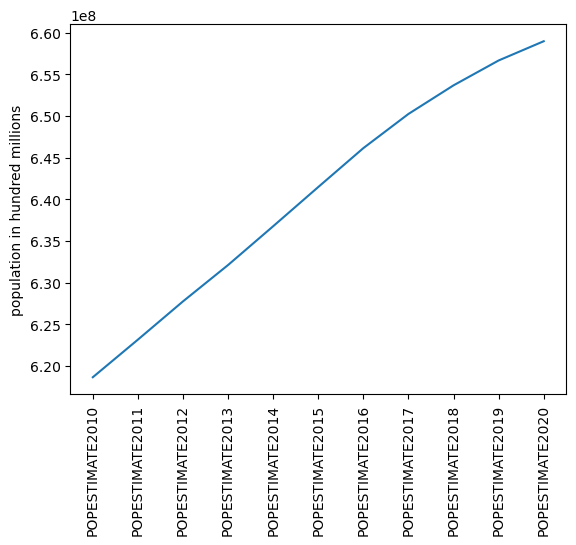

In [104]:
population_by_state = counties.pivot_table(index= "STNAME", values=['POPESTIMATE2010',
        'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013',
        'POPESTIMATE2014', 'POPESTIMATE2015', 'POPESTIMATE2016',
        'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019',
        'POPESTIMATE042020', 'POPESTIMATE2020'], aggfunc=sum)

plt.xticks(rotation='vertical')
plt.ylabel("population in hundred millions")
plt.plot(population_by_state.sum()[1:])

The sum of the populations of each state according to county estimates is around double the population of the US. A possible solution is to find an outside source of data and compare the estimates to find something more accurate.

## Part 2: Exploratory Data Analysis (EDA)

### Query 2a.)

Creating a vertical bar chart that shows the median increase in number of cases for the 50 counties with the greatest median increase over January 23, 2020 to September 12, 2021.

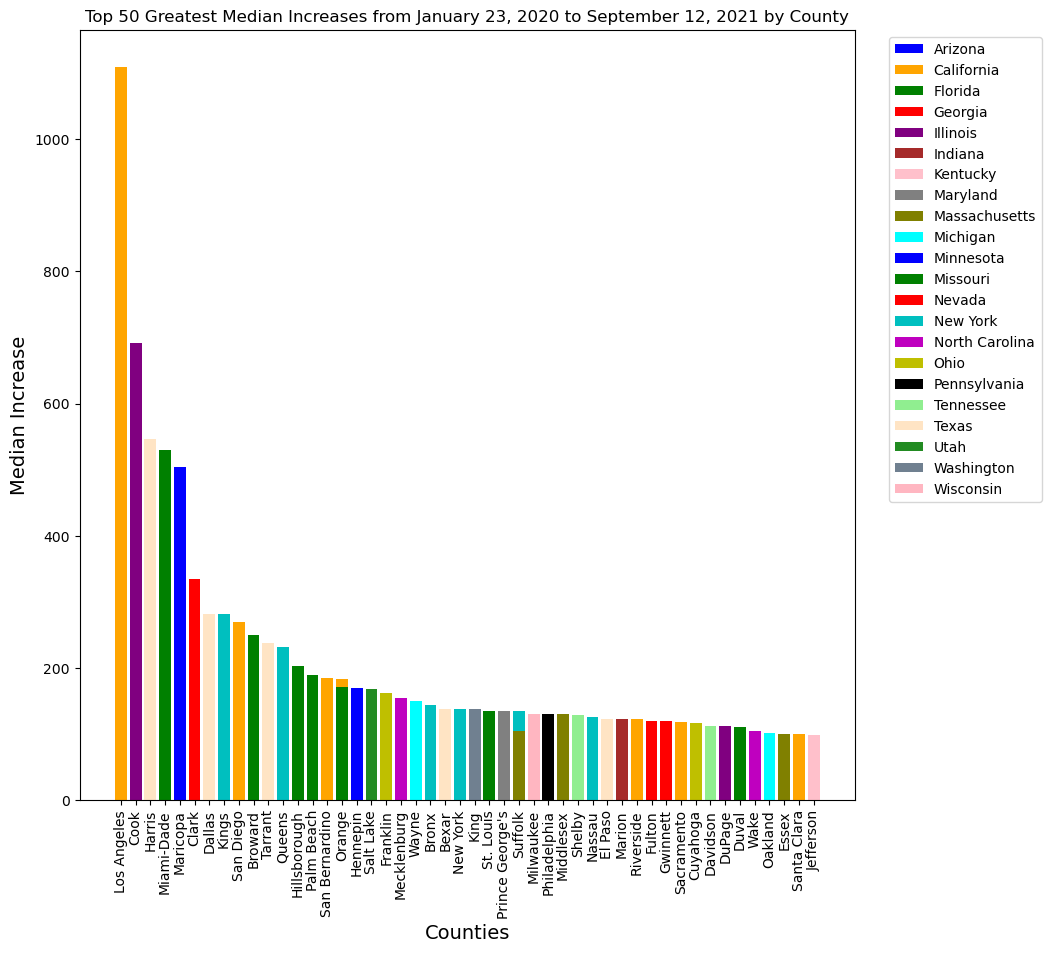

In [105]:
top_50_median_increase = county_data.sort_values("median_increase", ascending=False).head(50)
top_50_median_increase['CTYNAME_short'] = [s[:-7] for s in top_50_median_increase.CTYNAME.values]

colors = {'Arizona':'blue',
 'California':'orange',
 'Florida':'green',
 'Georgia':'red',
 'Illinois':'purple',
 'Indiana':'brown',
 'Kentucky':'pink',
 'Maryland':'gray',
 'Massachusetts':'olive',
 'Michigan':'cyan',
 'Minnesota':'b',
 'Missouri':'g',
 'Nevada':'r',
 'New York':'c',
 'North Carolina':'m',
 'Ohio':'y',
 'Pennsylvania':'k',
 'Tennessee':'lightgreen',
 'Texas':'bisque',
 'Utah':'forestgreen',
 'Washington':'slategrey',
 'Wisconsin':'lightpink'}

c = top_50_median_increase['STNAME'].apply(lambda x: colors[x])

fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation='vertical')

bars = ax.bar(top_50_median_increase.CTYNAME_short, top_50_median_increase.median_increase, color=c)

for i, j in colors.items():
    ax.bar(top_50_median_increase.CTYNAME_short, top_50_median_increase.median_increase,width=0,color=j,label=i)

ax.legend(bbox_to_anchor=(1.25, 1))
plt.xlabel('Counties', fontsize = 14)
plt.ylabel('Median Increase', fontsize = 14)
plt.title('Top 50 Greatest Median Increases from January 23, 2020 to September 12, 2021 by County')
plt.show()

### Query 2b.)

Creating a scatterplot that highlights the overall county-wise distribution of COVID-19 cases per capita across the U.S. as a function of time. (using population estimates from 2020)

Text(0.5, 1.0, 'Proportion of Cases by County from January 23, 2020 to September 12, 2021')

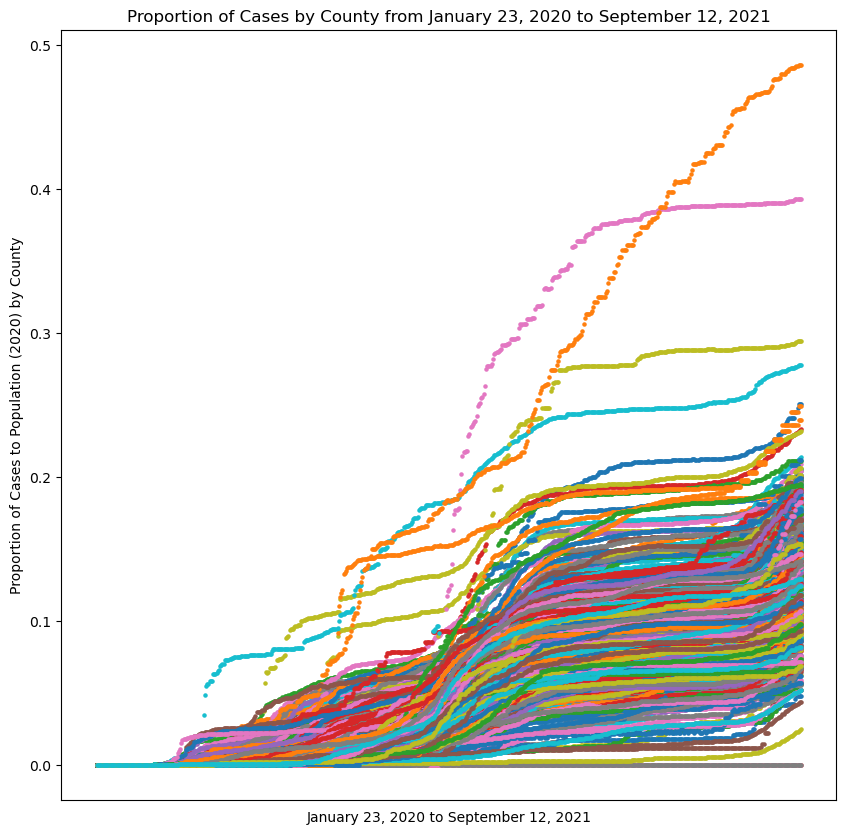

In [106]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation='vertical')
county_data.iloc[:,32:632].values, county_data.iloc[:,32:632].columns

for i in np.arange(600):
    y = county_data.iloc[:,32:632].values[i]/county_data.POPESTIMATE2020[i]
    x = county_data.iloc[:,32:632].columns
    plt.scatter(x=x,y=y, s=5) 
    
plt.tick_params( axis = 'x', which = 'both', top = False, labelbottom = False, width = 0)
plt.ylabel("Proportion of Cases to Population (2020) by County")
plt.xlabel("January 23, 2020 to September 12, 2021")
plt.title("Proportion of Cases by County from January 23, 2020 to September 12, 2021")

### Query 2c.)

Creating a barchart that shows states' increases in the number of COVID-19 cases per capita from September 3rd to September 12th, sorted from least to greatest increases. 

Text(0.5, 1.0, 'Increase in Cases from Sep 3rd to Sep 12th')

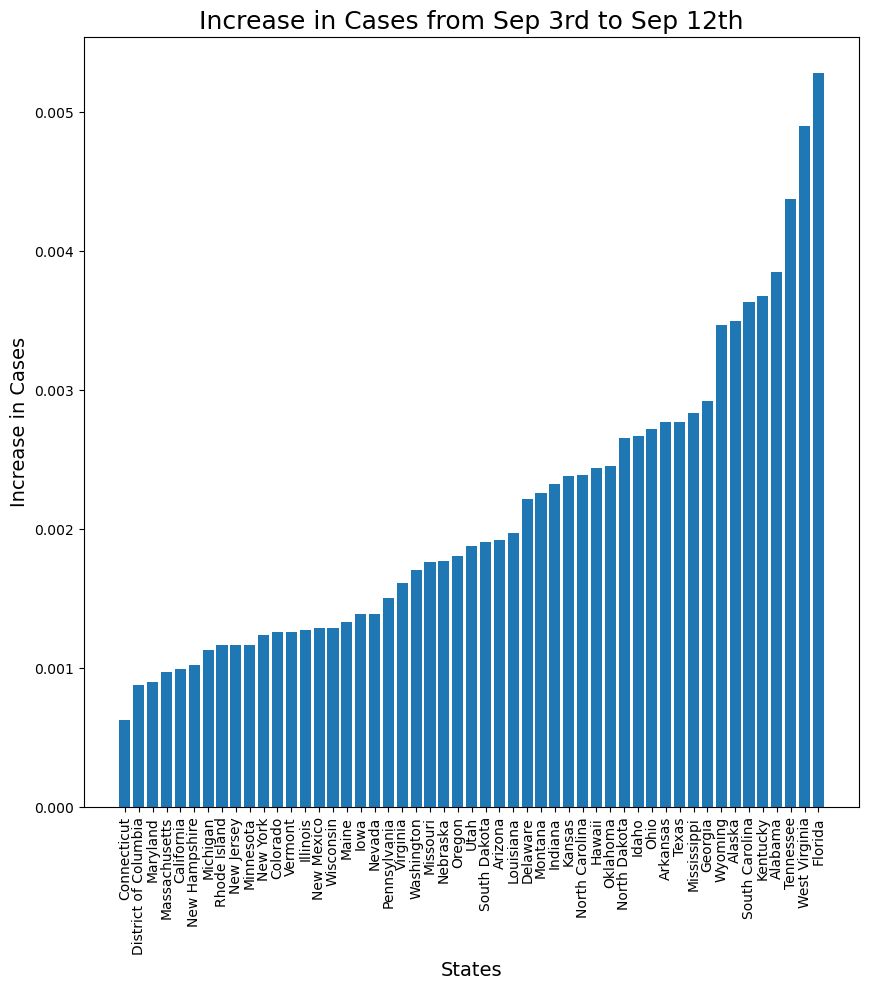

In [107]:
chart_case1 = pd.DataFrame(cases['Province_State'])
chart_case2 = cases.iloc[:, 600:619].drop(columns = ['median_increase'])
chart_case = pd.concat([chart_case1, chart_case2], axis = 1)
find_states = vaccinations['Province_State']
findstates2 = counties.groupby('STNAME').agg(sum).index
final_states = []
for i in find_states:
    for f in findstates2:
        if i == f:
            final_states.append(i)
state_series = pd.Series(final_states)
pop = counties.groupby('STNAME').agg(sum)['POPESTIMATE2020']
chart_case = chart_case[chart_case['Province_State'].isin(state_series)]
chart_case = chart_case.groupby('Province_State').agg(sum)
chart_case = chart_case.apply(lambda x: x/pop)
chart_case['Increase'] = chart_case['9/12/21'] - chart_case['9/2/21']
chart_case = chart_case[['Increase']]
chart_case = chart_case.sort_values('Increase')
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation='vertical')
plt.bar(chart_case.index, chart_case['Increase']) 
plt.xlabel('States', fontsize = 14)
plt.ylabel('Increase in Cases', fontsize = 14)
plt.title('Increase in Cases from Sep 3rd to Sep 12th', fontsize = 18)

### Query 2d.)

Creating a time series line plot that visualizes the number of COVID-19 cases as a function of time for the Mobile, Tarrant, Cook, and San Fransisco counties located in Alabama, Texas, Illinois, and California.

Text(0.5, 1.0, 'Number of Cases as a Function of Time of Respective Counties')

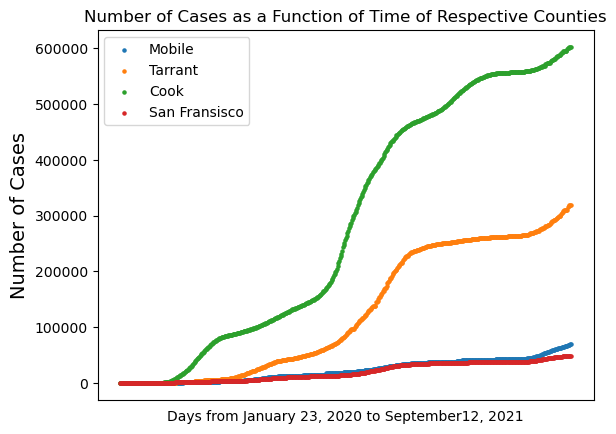

In [108]:
plt.xticks(rotation='vertical')
county_data.iloc[:,32:632].values, county_data.iloc[:,32:632].columns

Mobile = county_data[county_data['FIPS'] == 1097] 
plt.scatter(Mobile.iloc[:,32:632].columns,Mobile.iloc[:,32:632].values, label = 'Mobile', s=5)

Tarrant = county_data[county_data['FIPS'] == 48439] 
plt.scatter(Tarrant.iloc[:,32:632].columns,Tarrant.iloc[:,32:632].values, label = 'Tarrant', s=5)

Cook = county_data[county_data['FIPS'] == 17031] 
plt.scatter(Cook.iloc[:,32:632].columns,Cook.iloc[:,32:632].values, label = 'Cook', s=5)

San_Fransisco = county_data[county_data['FIPS'] == 6075] 
plt.scatter(San_Fransisco.iloc[:,32:632].columns,San_Fransisco.iloc[:,32:632].values, label = 'San Fransisco', s=5)
plt.tick_params( axis = 'x', which = 'both', top = False, labelbottom = False, width = 0)
plt.xlabel('Days from January 23, 2020 to September12, 2021')
plt.ylabel('Number of Cases', fontsize = 14)
plt.legend()
plt.title('Number of Cases as a Function of Time of Respective Counties')

### Query 2e.)

Creating a grouped bar chart that visualizes the frequency of never, rarely, or sometimes wearing a mask in the respective counties.

Text(0.5, 1.0, 'Frequency of Never, Rarely, or Sometimes, for Masking Wearing in the Respective Counties')

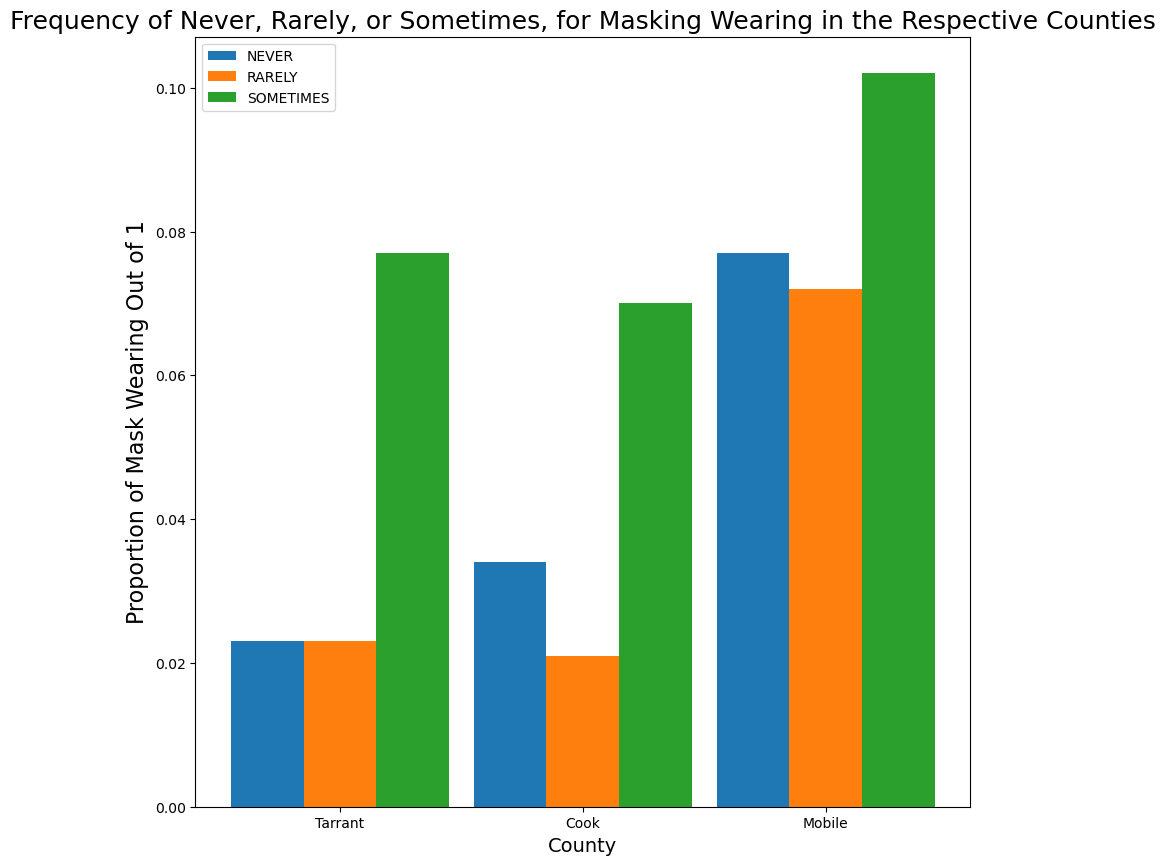

In [109]:
hello = pd.concat([Tarrant, Cook, Mobile], axis = 0)
hello = hello[['NEVER', 'RARELY', 'SOMETIMES']]
hello = hello.rename(index = {2741: 'Tarrant', 609 : 'Cook', 48: 'Mobile'})
X_axis = np.arange(len(hello.index))
fig, ax = plt.subplots(figsize=(10,10))
plt.bar(X_axis - 0.3, hello.iloc[0], 0.3, label = 'NEVER')
plt.bar(X_axis, hello.iloc[1], 0.3, label = 'RARELY')
plt.bar(X_axis + 0.3, hello.iloc[2], 0.3, label = 'SOMETIMES')
plt.xticks(X_axis, hello.index)
plt.legend()
plt.xlabel('County', fontsize = 14)
plt.ylabel('Proportion of Mask Wearing Out of 1', fontsize = 16)
plt.title('Frequency of Never, Rarely, or Sometimes, for Masking Wearing in the Respective Counties', fontsize = 18)

## Query 2f.)

Creating heatmaps that describe the spatial relationship between the location and the following quantities over the contiguous United States:

1. The number of most recent COVID-19 cases per capita on September 12, 2021

2. The frequency of never, rarely, or sometimes wearing a mask

In [ ]:
# The number of most recent covid-10 cases per capita on 9/12/2021

county_data_contiguous = county_data[~county_data["Province_State"].isin(['Alaska', 'Hawaii', 'American Samoa', 'Diamond Princess', 'Grand Princess', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands'])]
county_data_contiguous['cases per capita on 9/12/21'] = county_data_contiguous['9/12/21'].values/county_data_contiguous['POPESTIMATE2020'].values

fig = px.density_mapbox(county_data_contiguous, lat='Lat', lon='Long_', z='cases per capita on 9/12/21', radius=15,
                        center=dict(lat=40, lon=-100), zoom=3,
                        mapbox_style="stamen-terrain")
fig.show()

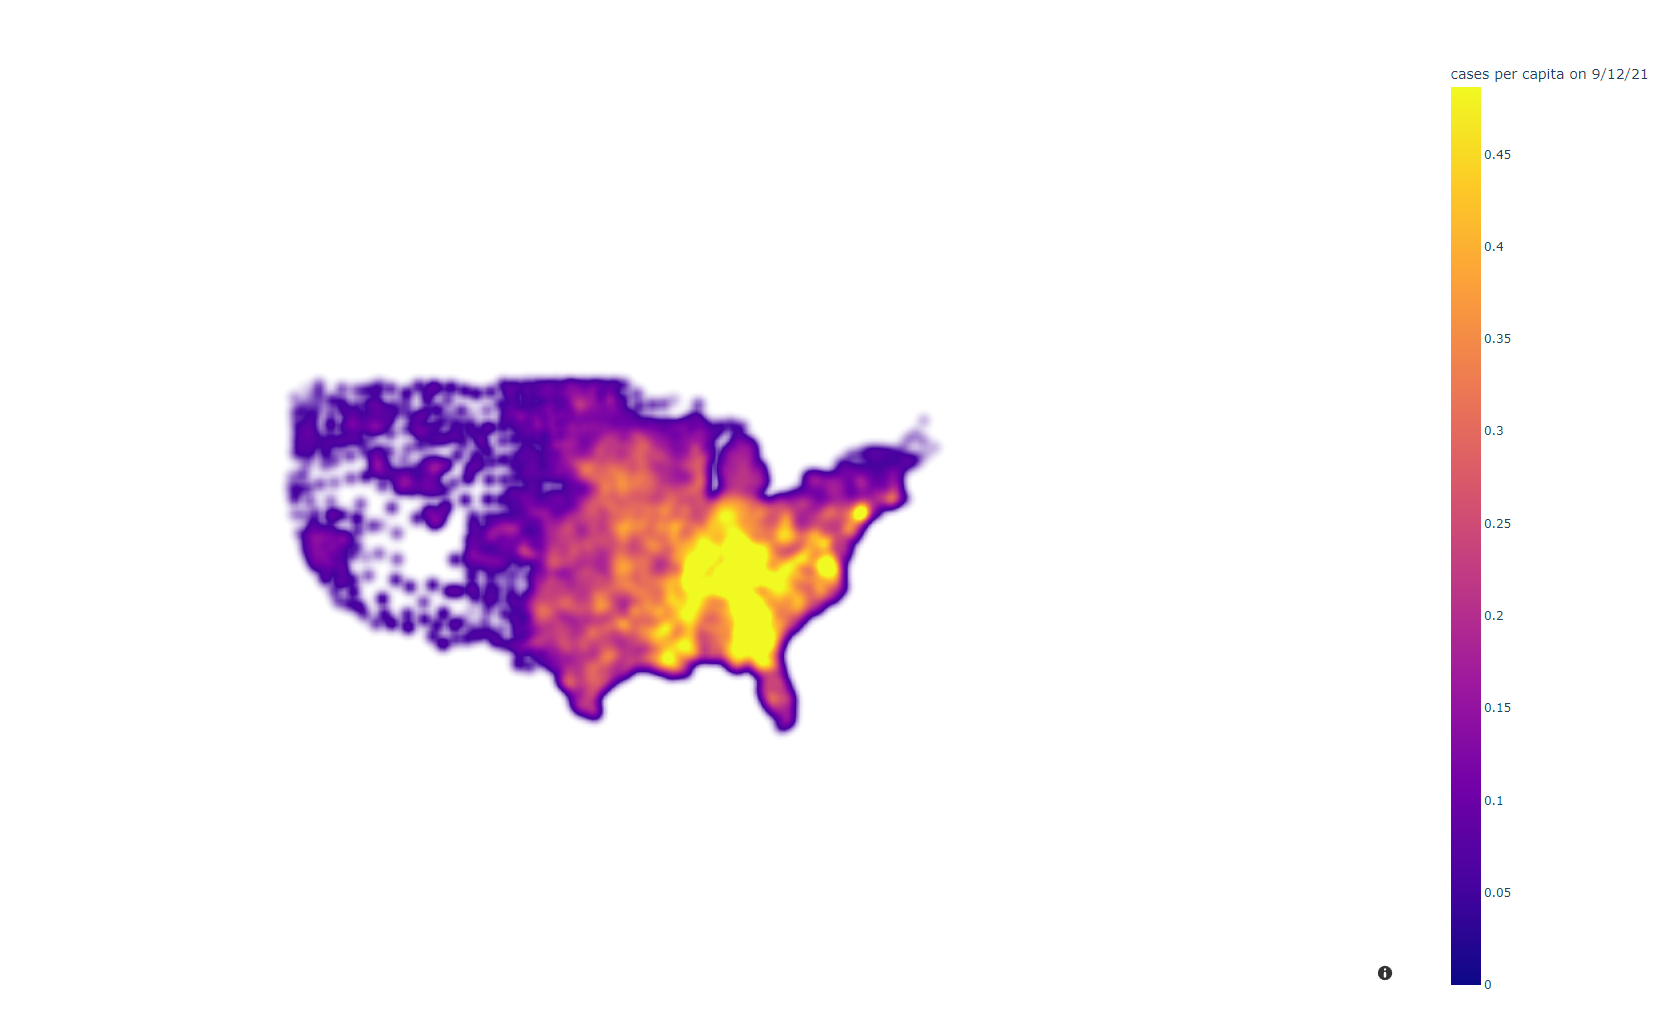

In [ ]:
# The frequency of never, rarely, or sometimes wearing a mask

n = county_data_contiguous.NEVER
r = county_data_contiguous.RARELY
s = county_data_contiguous.SOMETIMES
f = county_data_contiguous.FREQUENTLY
a = county_data_contiguous.ALWAYS
maskage = n+r*10+s*100+f*1000+a*10000
county_data_contiguous['maskage'] = maskage

fig = px.density_mapbox(county_data_contiguous, lat='Lat', lon='Long_', z='maskage', radius=10,
                        center=dict(lat=40, lon=-100), zoom=3,
                        mapbox_style="stamen-terrain")
fig.show()

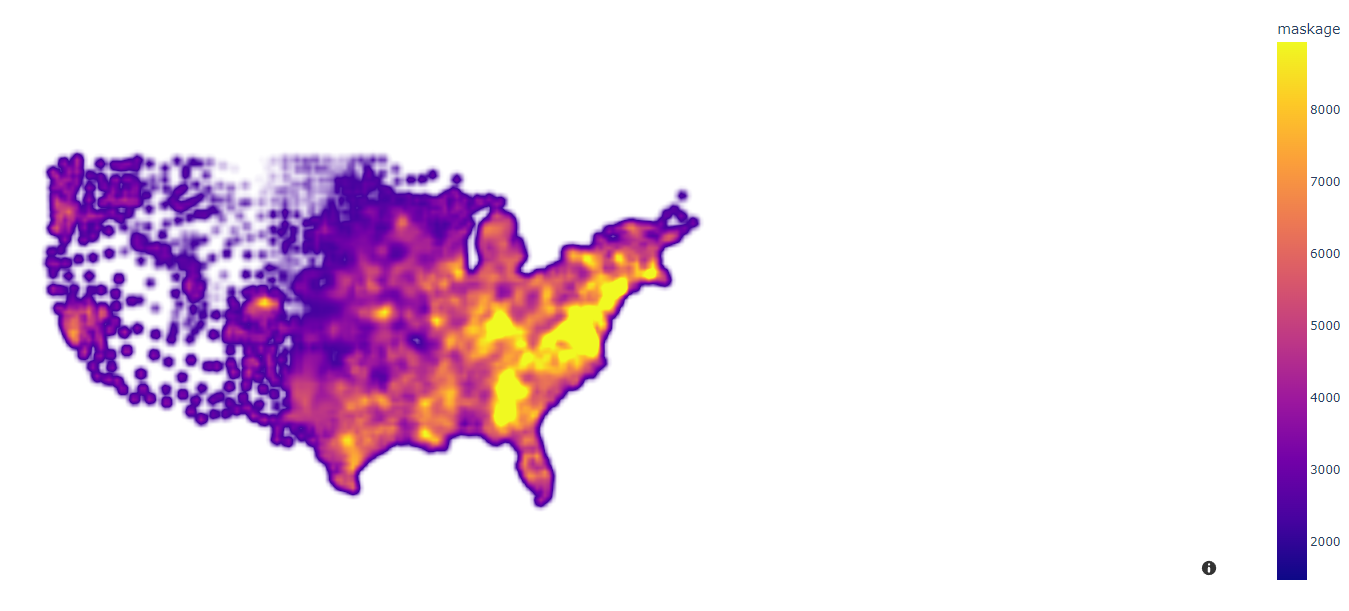

### Conclusions from the Plots

* The visualizations that show over time growth in covid cases all show a clear positive correlation between time and increase in covid cases.
* The visualizations that show county wide comparisons on the specific recently recorded date of Sep 12 show that states known to be heavily populated had larger total cases and cases per capita.
* High mask usage is correlated with higher covid rates, likely because the news of a covid outbreak in their area will have people more likely wear masks outside as a response.

## Part 3: Unsupervised Exploration

### Query 3a.)

Decomposed the standardized matrix $X$ that contains the standardized current proportion of fully vaccinated and partially vaccinated, cases per capita, and mask usage for every state as of the most recent day in the data using SVD.

In [110]:
vacc = vaccinations[vaccinations['Date'] == '2021-09-12']
find_states = vacc['Province_State']
findstates2 = counties.groupby('STNAME').agg(sum).index
final_states = []
for i in find_states:
    for f in findstates2:
        if i == f:
            final_states.append(i)
state_series = pd.Series(final_states)
vacc = vacc[vacc['Province_State'].isin(state_series)]
vacc = vacc[['Province_State', 'People_Fully_Vaccinated', 'People_Partially_Vaccinated']].set_index('Province_State')
pop = counties.groupby('STNAME').agg(sum)['POPESTIMATE2020']
vacc = vacc.apply(lambda x: x/pop)
vacc

,People_Fully_Vaccinated,People_Partially_Vaccinated
Province_State,,
Alabama,0.200247,0.055168
Alaska,0.245093,0.037277
Arizona,0.243539,0.040769
Arkansas,0.217522,0.054010
California,0.293301,0.065035
Colorado,0.291275,0.031660
Connecticut,0.336308,0.037886
Delaware,0.277269,0.042887
District of Columbia,0.358335,0.050834


In [ ]:
# filtering/aggregating COVID-19 Case Data by state and calcuating mean mask usage for each state

case_cap = cases[cases['Province_State'].isin(state_series)]
case_cap = case_cap.groupby('Province_State').agg(sum)['9/12/21']
state_county = county_data[county_data['STNAME'].isin(state_series)]
mask_ratio = state_county.groupby('STNAME').agg(np.mean)
mask_ratio = mask_ratio[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
mask_ratio['County_Pop'] = pop

In [ ]:
# the following code combines mask usage and vaccination data, calculates cases per capita, standardizes the data, and drops unnecessary columns

state_final = pd.concat([mask_ratio, vacc], axis = 1)
state_final['Cases'] = case_cap
state_final['Cases_per_Capita'] = state_final['Cases']/state_final['County_Pop']
state_final = state_final.drop(['County_Pop', 'Cases'], axis = 1)
state_final = ((state_final - np.mean(state_final, axis = 0))/ np.std(state_final, axis = 0))

In [ ]:
# perform singular value decomposition on the 'state_final' dataframe

X = state_final
u, s, vt = np.linalg.svd(X, full_matrices = False)

In [ ]:
X

| State                | NEVER    | RARELY   | SOMETIMES | FREQUENTLY | ALWAYS   | People_Fully_Vaccinated | People_Partially_Vaccinated | Cases_per_Capita |
|----------------------|----------|----------|-----------|------------|----------|--------------------------|-----------------------------|------------------|
| Alabama              | 0.288218 | 0.193507 | 1.037292  | 0.412209   | -0.51619 | -1.503526                | 1.002947                    | 1.060731         |
| Alaska               | -0.338856| -0.226483| -0.426311 | 3.249055   | -0.677091| -0.487985                | -0.2778                     | 0.291899         |
| Arizona              | -0.484477| -0.479249| -0.335099 | -1.161207  | 0.687076 | -0.523189                | -0.027815                   | 0.685384         |
| Arkansas             | 0.514763 | 0.342191 | 0.819277  | 0.53444    | -0.59954 | -1.112326                | 0.920001                    | 1.23172          |
| California           | -0.904883| -1.021415| -1.15351  | -0.900472  | 1.08644  | 0.603659                 | 1.709306                    | -0.293752        |
| Colorado             | -0.739061| -0.02726 | -0.266435 | 1.082775   | -0.033213| 0.557794                 | -0.679903                   | -0.445711        |
| Connecticut          | -1.26362 | -1.207738| -1.419418 | -1.646079  | 1.520788 | 1.577533                 | -0.234221                   | -0.544278        |
| Delaware             | -1.219213| -1.601734| -1.233377 | -2.356519  | 1.77637  | 0.240621                 | 0.123802                    | 0.171881         |
| District of Columbia | -1.396841| -1.44896 | -1.013211 | -0.775622  | 1.276366 | 2.076341                 | 0.692701                    | -1.48572         |
| Florida              | -0.349147| -0.374984| 0.079076  | -0.074664  | 0.201932 | 0.11427                  | 0.725968                    | 1.306983         |
| Georgia              | 0.330999 | 0.128083 | 0.496548  | 0.052439   | -0.268414| -1.234917                | 0.602773                    | 0.589643         |
| Hawaii               | -1.295109| -1.309051| -1.953761 | -1.872225  | 1.758513 | 1.387448                 | 3.949434                    | -2.505238        |
| Idaho                | 0.826083 | 1.730232 | 0.9887    | 0.516262   | -1.108644| -1.386477                | -1.092659                   | 0.216334         |
| Illinois             | 0.063131 | -0.042307| 0.515779  | 0.508148   | -0.283387| 0.112963                 | 2.437736                    | 0.083565         |
| Indiana              | 0.39796  | 0.563668 | 0.609606  | 0.911478   | -0.684245| -0.726246                | -1.532784                   | 0.399513         |
| Iowa                 | 0.839417 | 1.067542 | 1.587152  | 0.39749    | -1.045958| -0.094886                | -1.383092                   | 0.351726         |
| Kansas               | 1.143706 | 1.058367 | 1.156244  | 0.507603   | -1.050053| -0.432433                | 0.278849                    | 0.39786          |
| Kentucky             | 0.403665 | 0.242607 | 0.627248  | 0.242128   | -0.408467| -0.384371                | 0.178733                    | 0.588577         |
| Louisiana            | 0.306651 | -0.014822| 0.18642   | 0.222801   | -0.192464| -1.13182                 | -0.348522                   | 1.113473         |
| Maine                | -0.536958| -0.340848| -0.192541 | 0.08616    | 0.26771  | 1.487784                 | -0.866198                   | -2.203222        |
| Maryland             | -1.132417| -1.257993| -1.474459 | -0.825748  | 1.274692 | 1.070252                 | -0.575391                   | -1.330447        |
| Massachusetts        | -1.215176| -1.478251| -1.775615 | -1.535774  | 1.639889 | 1.523114                 | 0.434751                    | -0.325481        |
| Michigan             | -0.602475| -0.284702| -0.186553 | 0.49402    | 0.150068 | -0.230574                | -1.270976                   | -0.450405        |
| Minnesota            | 0.812099 | 1.188397 | 1.277429  | 1.054974   | -1.184396| 0.393323                 | -0.932919                   | -0.145293        |
| Mississippi          | -0.044837| 0.275481 | 0.321963  | 0.085736   | -0.170889| -1.370278                | -0.182607                   | 1.175692         |
| Missouri             | 1.559724 | 1.304952 | 1.170455  | 0.301064   | -1.177514| -0.804703                | -0.325236                   | 0.239742         |
| Montana              | 1.966564 | 2.376557 | 0.991874  | 0.407572   | -1.572745| -0.767117                | -0.743215                   | 0.064586         |
| Nebraska             | 1.311341 | 1.076864 | 1.014591  | 1.475694   | -1.345628| -0.041125                | -1.093616                   | 0.307753         |
| Nevada               | -0.977942| -0.753674| -0.015469 | -0.091096  | 0.510605 | -0.583623                | 0.594633                    | 0.217429         |
| New Hampshire        | -0.352871| -0.373111| -0.894321 | -0.229634  | 0.494888 | 0.784538                 | -0.224978                   | -1.435943        |
| New Jersey           | -1.132705| -1.250239| -1.530287 | -0.916636  | 1.312719 | 1.222594                 | 0.071692                    | 0.137723         |
| New Mexico           | -0.665776| -0.565212| -0.759419 | -0.875173  | 0.787524 | 0.859108                 | 0.57821                     | -0.284028        |
| New York             | -1.134305| -1.220967| -1.531383 | -1.440196  | 1.456739 | 0.988382                 | -0.285701                   | -0.039853        |
| North Carolina       | -0.384844| -0.63942 | -0.24624  | 0.018374   | 0.340936 | -0.32461                 | 0.477103                    | -0.043157        |
| North Dakota         | 2.696229 | 2.193942 | 1.019131  | 1.255899   | -1.976478| -1.203423                | -0.481345                   | 1.352135         |
| Ohio                 | 0.527711 | 0.690786 | 1.13401   | 0.466311   | -0.760352| -0.467024                | -1.473471                   | -0.384161        |
| Oklahoma             | 0.743508 | 1.151221 | 1.566337  | 0.660255   | -1.11358 | -0.914604                | 0.401768                    | 0.817349         |
| Oregon               | -0.799364| -0.580562| -0.574346 | -0.215882  | 0.58942  | 0.622446                 | -0.756966                   | -1.837181        |
| Pennsylvania         | -0.819489| -0.908911| -0.557368 | -0.621618  | 0.800717 | 0.337016                 | 2.197843                    | -0.586338        |
| Rhode Island         | -1.391997| -1.530975| -1.779389 | -1.423404  | 1.671458 | 2.126755                 | -0.411618                   | 1.236949         |
| South Carolina       | 0.665193 | -0.060887| 0.051053  | -0.168075  | -0.131058| -1.018317                | 0.013505                    | 1.002464         |
| South Dakota         | 1.905065 | 0.771741 | 1.567537  | 0.49891    | -1.282093| -0.410303                | -0.339181                   | 1.106841         |
| Tennessee            | 0.97794  | 0.682424 | 1.178532  | 0.277633   | -0.838451| -1.133939                | -0.168014                   | 1.46428          |
| Texas                | -0.430629| -0.323006| -0.268356 | -0.204987  | 0.335907 | -0.55507                 | 0.348802                    | 0.294357         |
| Utah                 | 0.566816 | 0.57647  | 0.288655  | 1.719775   | -0.888212| -0.411822                | 0.138587                    | 0.911676         |
| Vermont              | -0.588863| 0.355033 | -1.005662 | -1.385396  | 0.720559 | 2.004753                 | -0.011323                   | -2.603747        |
| Virginia             | -0.673276| -0.64259 | -0.299276 | -0.455384  | 0.572078 | 0.539246                 | -0.06985                    | -1.010968        |
| Washington           | -0.769552| -0.824876| -0.969178 | -0.349699  | 0.786665 | 0.832921                 | -0.096542                   | -1.56442         |
| West Virginia        | 0.397352 | 0.096613 | 0.758367  | 0.483767   | -0.468613| -0.842738                | -0.223545                   | -0.14486         |
| Wisconsin            | 0.415776 | 0.698918 | 1.004245  | 0.804953   | -0.796193| 0.180915                 | -1.251704                   | 0.259962         |
| Wyoming              | 1.984768 | 2.024632 | 0.413466  | 0.797563   | -1.446188| -1.546331                | -0.51795                    | 0.585976         |


### Query 3b.)

Visualizing the top 2 principal components and labeling the data points with the corresponding location.

In [ ]:
import plotly.express as px
vt_t = (vt[0:2, :].transpose())
pca_graph = X @ vt_t
states = pca_graph.index.tolist()
pca_graph = pca_graph.rename(columns = {0 : 'Principal Component 1', 1 : 'Principal Component 2'})
pca_concat = pd.concat([pca_graph, X], axis = 1)
pgraph = px.scatter(pca_concat, x = 'Principal Component 1', y = 'Principal Component 2', text = states, title = 'Principle Component Comparison')
pgraph

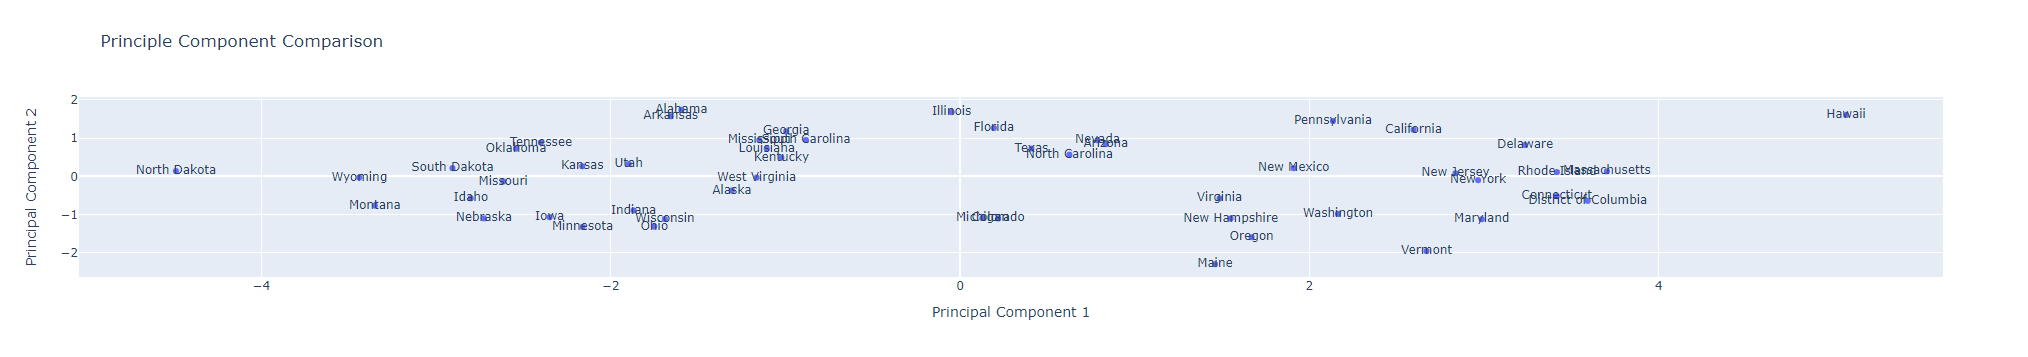

###  What might each of the principal components be?

I hypothesize that the first principal component represents the proximity to coast, with positive values meaning very close to the coast, and negative values indicating more inland/midwest areas. For the second principal component, we hypothesize that it indicates population density for those states, with positive principal component values indicating higher population densities, and lower for negative values. Based on this visualization, we can interpret that midwest states with lower population densities tend to correlate togheter, which aligns with our analysis of mask usage in question 4 (refer to question 4). Vice versa, coastal states with higher population densities tend to correlate together.

### Query 3c.)

Constructing a scree plot displaying the proportion of variance captured by each principal component.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Load Dataset

# define columns to use for PCA

df = X.iloc[:,:]

# define Scaler 

scaler = StandardScaler()

scaled_df = df.copy()
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

# 2. Perform PCF

# define PCA model to use
pca = PCA(n_components = 8)
#fit PCA model to data
pca_fit = pca.fit(scaled_df)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='red')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

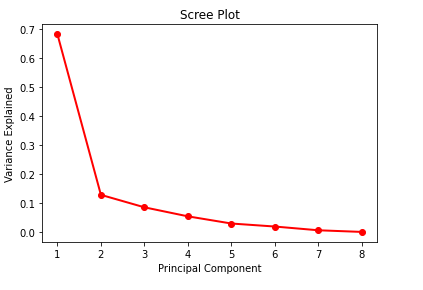

### Query 3d.)

In the analysis, the 2D representation of each state's first two principal components, denoted as  $x_i = [\text{PC}_1, \text{PC}_2]$, was utilized to identify the 5 closest principal component neighbors for each state using Euclidean distance as the metric. Essentially, for each state $i$ with the first two principal components $x_i$, its closest principal component neighbor was determined by the expression:

$$
\arg \min_{j \ne i} ||x_j - x_i||_2
$$

The five closest neighbors for each state were then stored in a Pandas DataFrame, where the index represented the state's name and the columns comprised the five closest PC neighbors.

In [ ]:
def euclidean_distance(ox,oy, x, y):
    
    return np.sqrt((ox-x)**2 + (oy-y)**2)

all_pcs = X@vt.T
X_2_pcs = all_pcs.iloc[:,0:2].rename({0:"pc1", 1:"pc2"}, axis = 1)
x = X_2_pcs['pc1']
y = X_2_pcs['pc2']
X_2_pcs.reset_index(inplace= True)
X_2_pcs = X_2_pcs.rename(columns = {'index': 'State'})
states= X_2_pcs["State"]

for state in states:
    X_2_pcs[state] = np.arange(51)
    
alls = []

for state in np.arange(len(states)):
    for a,b in zip(x,y):
        alls = np.append(alls, euclidean_distance(x[state],y[state],a,b))
i = 0
position = 0
working = []

for a in np.arange(len(states)):
        working = np.append(working, alls[i])
        if (i + 51) != 2601:
            i+= 51
            
for state in states:
    
    if working != []:
        X_2_pcs[state] = working
        working = []
        position += 1
        i = 0
        i += position
        
    for a in np.arange(len(states)):
        working = np.append(working, alls[i])
        
        if (i + 51) != 2601:
            i+= 51
            
distances = X_2_pcs.set_index("State").iloc[:,2:]
top_5 = X_2_pcs.T.iloc[:,:5].T
top_5.set_index("State", inplace= True)
top_5 = top_5.iloc[:,2:].T

i = 0
for state in states:
    working = distances.nsmallest(6, state)[state].index
    working = working[1:]
    top_5.iloc[i] = working
    i+= 1
    
top_5.reset_index(inplace=False)
top_5 = top_5.rename(columns = {"Alabama": "1st", "Alaska": "2nd", "Arizona" : "3rd", "Arkansas" : "4th", "California": "5th"})
state_mins = top_5
state_mins.head(10)

| State              | 1st              | 2nd             | 3rd           | 4th            | 5th         |
|--------------------|------------------|-----------------|---------------|----------------|-------------|
| Alabama            | Arkansas         | Georgia         | Mississippi   | South Carolina | Louisiana   |
| Alaska             | West Virginia    | Indiana         | Wisconsin     | Kentucky       | Utah        |
| Arizona            | Nevada           | North Carolina  | Texas         | Florida        | Illinois    |
| Arkansas           | Alabama          | Georgia         | Mississippi   | South Carolina | Louisiana   |
| California         | Pennsylvania     | Delaware        | New Jersey    | New Mexico     | New York    |
| Colorado           | Michigan         | New Hampshire  | Virginia      | Oregon         | Alaska      |
| Connecticut        | District of Columbia | New York    | Rhode Island  | Massachusetts | Maryland    |
| Delaware           | Rhode Island     | California     | Massachusetts | New Jersey     | New York    |
| District of Columbia | Connecticut   | Rhode Island   | Maryland      | Massachusetts | New York    |
| Florida            | Illinois         | Texas           | Nevada        | Arizona        | North Carolina |


### Query 3e.)

I investigated the principal component neighbors for two states of my choice and remarked on any observations I had about their COVID-19 statistics given in the dataset, geographical, or politcal ties. I compared these neighbors with the rankings from the visualization from Query 2c that depicted recent greatest increases in cases across states.

In [ ]:
X.loc['Alabama'], X.loc['Arkansas'], X.loc['Georgia']

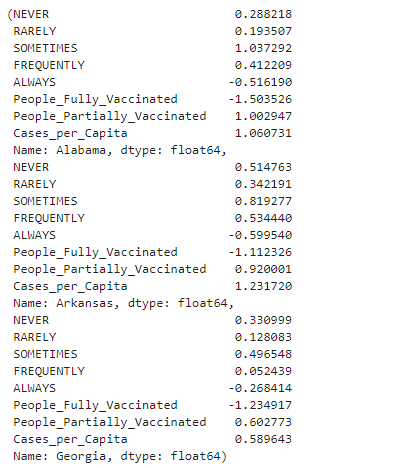

In [ ]:
X.loc['California'], X.loc['Pennsylvania'], X.loc['Delaware']

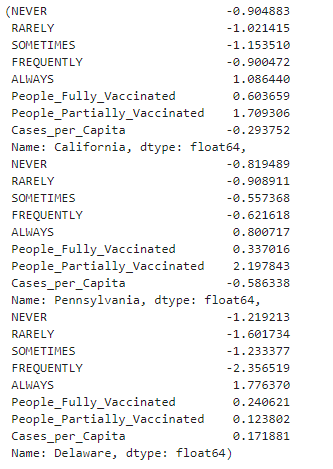

The two states I investigated are California and Alabama. I identified that California pc neighbors are Pennsylvania and Georgia. Alabama's were Arkansas and Georgia. Based on this info, I identified that these states tend to both be very similar geographical with these neighbors (coastal vs inland), and tend to vote in similar political affiliations (typically blue vs red states). In addition, we can observe from the data that there is a clear grouping where Alabama and its neighbors tended to have higher cases per capita, while California and its neighbors tended to have significantly lower cases per capita.

### Query 3f.)

I investigated the relationship between geographical distance in miles and the top two principal component distances between any two unique pairs of states.

For the sake of simplicity, I assumed that the singular geographical location of a state was given by the mean latitude and longitude of all the counties in that state. For each unique pair of states, I calculated the geographical distance and the Euclidean distance between their top 2 principal components. I plotted the relationship where the x-axis represented the top 2 principal component distance and the y-axis represented geographical distance.

In [ ]:
import geopy.distance

def euclidean_distance2(x, y):
    
    return np.sqrt(sum((pc2.iloc[x,:]-pc2.iloc[y,:])**2))

states = county_data.groupby('STNAME').agg(np.mean).reset_index(inplace=False)['STNAME']
coordinates = county_data[['Province_State','Lat','Long_']].groupby('Province_State').agg(np.mean)
distances = pd.DataFrame(columns = ['State 1','State 2','Euclidean','Geographical'], index = np.arange(0,2601,1))
pc2 = pca_graph

for i in range(pc2.shape[0]):
    
    for j in range(pc2.shape[0]):
        
        first_state = states[i]
        second_state = states[j]
        e_distance = euclidean_distance2(i,j)
        lat_long_1 = coordinates.loc[states[i],'Lat':"Long_"]
        lat_long_2 = coordinates.loc[states[j],'Lat':"Long_"]
        geographical_distance = geopy.distance.distance(lat_long_1, lat_long_2).miles
        new_entry = [first_state, second_state, e_distance, geographical_distance]
        distances.iloc[(51*i+j),:] = new_entry

distances = distances[distances['Euclidean'] != 0].drop_duplicates(subset=['Euclidean'])

x, y = distances.iloc[:,2],distances.iloc[:,3]

sns.scatterplot(x,y)
plt.title('Relationship between geographical distance in miles and top two principal component distance between any two unique pairs of states')
plt.xlabel('Top 2 Principal Component Distance')
plt.ylabel('Geographical Distance')
plt.show()

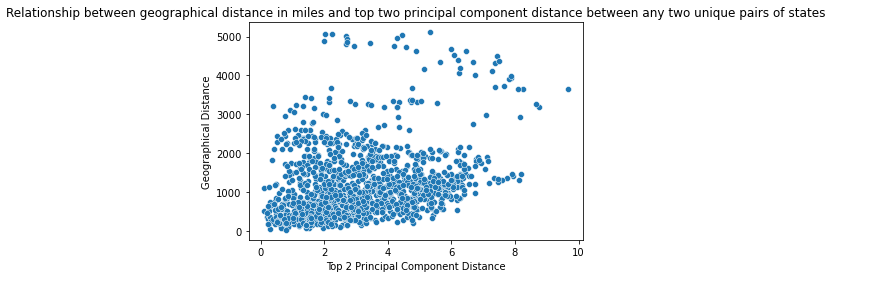

Based on the plot, it seems that two states in unique pair are typically likely to be close to each because there are more states in the inland statisically than those on the edges. The outliers of this plot are likely indicators of two states with geographical distances very distant, or in other words, two states on opposite coasts, or edge cases like Alaska. This implies that geographical distance can indicate similar correlations of data just like our diagnosis of Euclidean distance. 

## Part 4: Supervised Modeling

### Query 4a.)

Using county-wide mask usage data to predict the number of COVID-19 cases on September 12, 2021 and showing the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

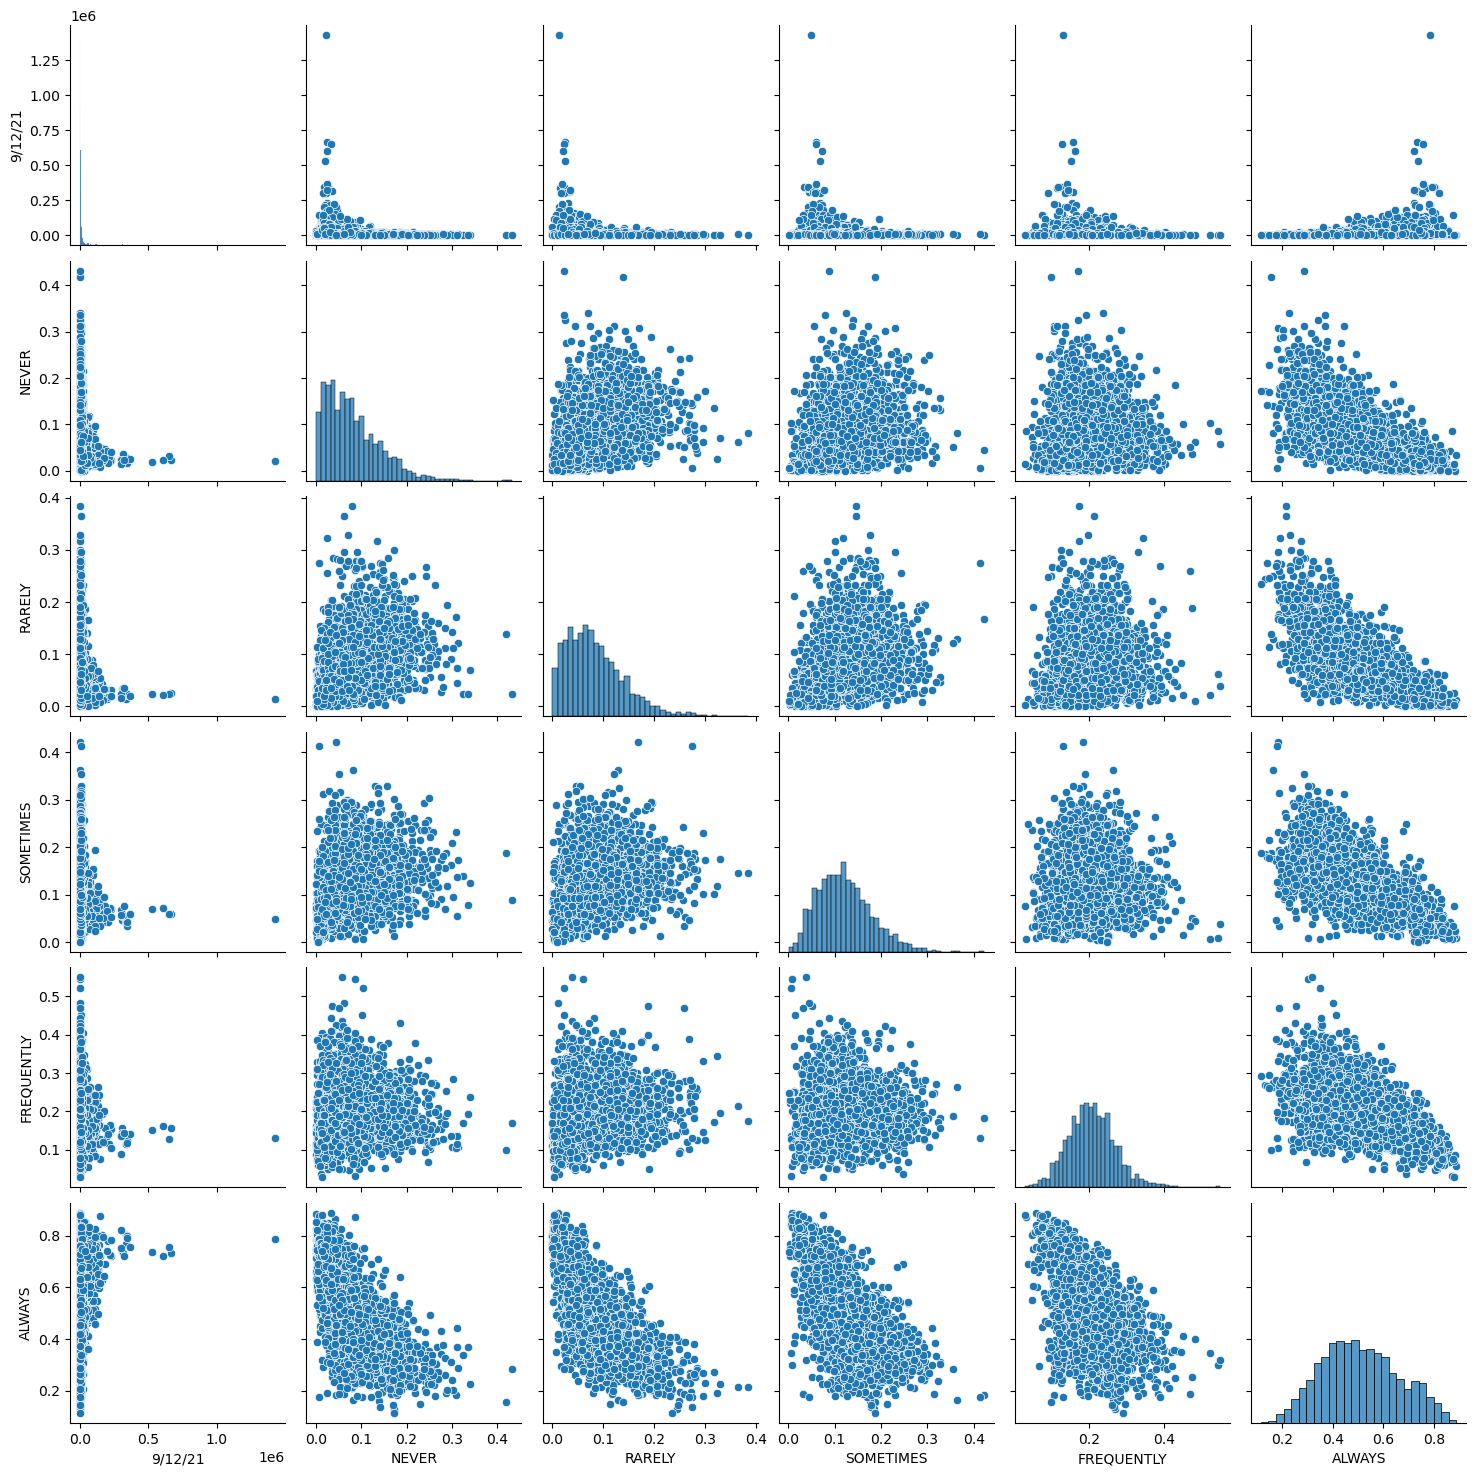

In [118]:
import seaborn as sn
sn.pairplot(county_data[['9/12/21', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']])

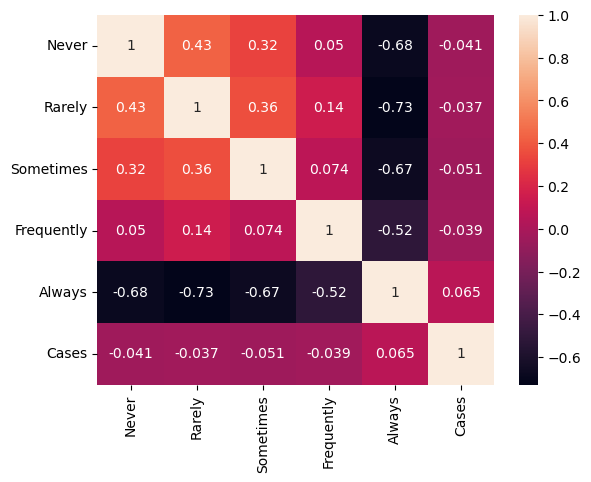

In [119]:
#pairwise correlation matrix

data = {'Never': mask_use['NEVER'],
        'Rarely': mask_use['RARELY'],
        'Sometimes': mask_use['SOMETIMES'],
        'Frequently': mask_use['FREQUENTLY'],
        'Always': mask_use['ALWAYS'],
        'Cases': cases['9/12/21']
        }

df = pd.DataFrame(data,columns=['Never','Rarely','Sometimes','Frequently','Always','Cases'])

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Query 4b.)

Trained a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. I evaluated my model's RMSE on a held-out validation set with 33% of the county-wise data and set random_state = 42 when splitting my data into training and test sets.

In [120]:
from sklearn.preprocessing import StandardScaler
num_vars = ['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']
scaler = StandardScaler()
scaler.fit(county_data[num_vars])
def design_matrix(t):
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    return pd.concat([scaled], axis=1)

X_q5b = design_matrix(county_data)
y_q5b = county_data['9/12/21']

# Make sure to set random_state = 42 and test_size = 0.33!
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, test_size = 0.33, random_state = 42)

train_model = LinearRegression().fit(X_q5b_train, y_q5b_train)
test_model = LinearRegression().fit(X_q5b_test, y_q5b_test)

train_y_predict = train_model.predict(X_q5b_train[num_vars])
test_y_predict = test_model.predict(X_q5b_test[num_vars])

train_rmse_cases = np.sqrt(np.mean((y_q5b_train - train_y_predict)**2))
test_rmse_cases = np.sqrt(np.mean((y_q5b_test - test_y_predict)**2))

train_rmse_cases, test_rmse_cases

(27834.430707426982, 61746.986125320414)

### What are potential reasons the test set RMSE is much higher than the training set RMSE?

Generally, the test set RMSE is higher than the training set RMSE because we overfit the training set and the test set contains data the model hasn't seen before. Therefore, if the test set RMSE is significantly higher than that of the training set RMSE, that would indicate that our model is definitely overfitting.

### Query 4c.)

Instead of predicting the number of Covid-19 cases, I redid part (b) by predicting the number of cases per capita and reporting the model's RMSE on the training and validation set.

In [123]:
X_q5d = design_matrix(county_data)
y_q5d = county_data['9/12/21']/county_data['POPESTIMATE2020']
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size = 0.33, random_state = 42)

train_model = LinearRegression().fit(X_q5d_train, y_q5d_train)
test_model = LinearRegression().fit(X_q5d_test, y_q5d_test)

train_y_predict = train_model.predict(X_q5d_train[num_vars])
test_y_predict = test_model.predict(X_q5d_test[num_vars])

train_rmse_cpc = np.sqrt(np.mean((y_q5d_train - train_y_predict)**2))
test_rmse_cpc = np.sqrt(np.mean((y_q5d_test - test_y_predict)**2))

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.038102432285342394)

### Query 4d.)

Visualizing the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$.

Text(0, 0.5, '$y$')

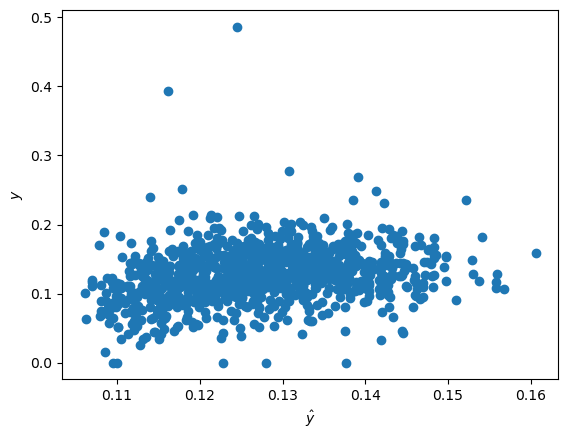

In [124]:
plt.scatter(test_y_predict, y_q5d_test)
plt.xlabel('$\hat{y}$')
plt.ylabel("$y$")

### Query 4e.)

Investigating the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behavior of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, I trained 1000 bootstrapped models on the training dataset from part (d).

In [125]:
models = []


for i in np.arange(1000):
    df_sample = X_q5d_train.sample(frac = 1, replace = True)
    lr = LinearRegression().fit(df_sample, y_q5d_train)
    models.append(lr)

### Query 4f.)

To investigate the variance in our test predictions, I sampled a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, I used the 100th point in the test set from part (d),  `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

I generated predictions and squared errors for this test point for all 1000 models, and calculated the proportion of the expected square error that was captured by the model prediction variance. In other words, I aimed to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

In [ ]:
prop_var = []
mse = []
var = []
for i in models:
    new_predict = i.predict(X_q5d_test.iloc[[100]])
    mse = np.append(mse, np.mean((y_q5d_test.iloc[[100]] - new_predict)**2))
    var = np.append(var, new_predict)
var = np.var(var)              
prop_var = np.mean(var/mse)
var, np.mean(mse)

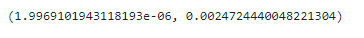

### Query 4g.)

Using bias-variance decomposition for each test point, I calculated the average variance and average test mean-square error across the entire test set from part (d). In other words, I estimated the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

In [ ]:
avg_var, avg_mse = [], []
modNum = 0
for i in models:
    # print("Model "+str(modNum)+"/1000...")
    single_var = []
    new_predict = i.predict(X_q5d_test)
    avg_mse = np.append(avg_mse, np.mean((y_q5d_test - new_predict)**2))
    single_var = np.append(single_var, new_predict)
    avg_var = np.append(avg_var, np.var(single_var))
    modNum += 1
avg_var, avg_mse = np.mean(avg_var), np.mean(avg_mse)
avg_var, avg_mse

### Possible solution to  to reducing the mean square error using the insights gained from the bias-variance decomposition above?

The biggest change one could make to reduce mean square error would be outlier removal.  However, just comparing the two examples above (4g with MSE $0.0024874730281933127$ and 4g with MSE $0.001560826884490373$) one of the best things I could do is to utilize the entire test set as opposed to using a singular test point.  Finally, one could also use more/better features or transforming the ones we have by for example taking the log or transforming features to be per capita as I did.

## Part 5: Final EDA for Hypothesis Testing

### Hypothesis: Higher death rates are correlated with higher vaccination rates; the more people you see dying, the more likely you are to get vaccinated. Specifically, I think that higher death rates are positively correlated with higher rates of vaccination in response.

### EDA 1.) 

For my initial exploratory data analysis, I compared month-to-month changes in vaccinations and deaths as a percentage difference for four states. These states were selected based on PCA data, with one state chosen from each hemisphere cluster. This approach aimed to discern any notable differences between states in terms of PCA regions. I did end up aggregating data for my second EDA. Additionally, to avoid overplotting, I did not include every single state in the analysis.

In [ ]:
# This code reads a CSV file containing death data, converts the "submission_date" column to datetime format, sorts the data by state and date, and assigns the sorted dataframe to the variable 'deaths'.

from datetime import datetime
deaths = pd.read_csv('deaths.csv')
deaths['dt'] = deaths['submission_date'].apply(datetime.strptime, args=('%m/%d/%Y',))
deaths = deaths.sort_values(["state", "dt"], ascending = (True, True))
deaths

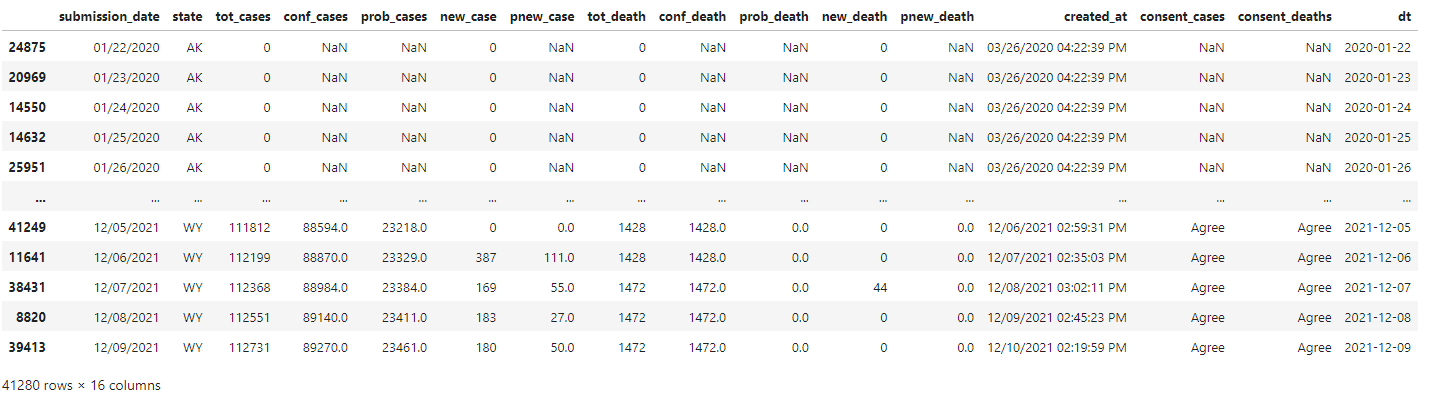

In [ ]:
# This code selects vaccination, population, and mask usage data for September 12, 2021, aggregates them by state, calculates vaccination rates and cases per capita, standardizes the data, performs Singular Value Decomposition (SVD), and visualizes the principal components using Plotly.

vacc = vaccinations[vaccinations['Date'] == '2021-09-12']
find_states = vacc['Province_State']
findstates2 = counties.groupby('STNAME').agg(sum).index
final_states = []
for i in find_states:
    for f in findstates2:
        if i == f:
            final_states.append(i)
state_series = pd.Series(final_states)
vacc = vacc[vacc['Province_State'].isin(state_series)]
vacc = vacc[['Province_State', 'People_Fully_Vaccinated', 'People_Partially_Vaccinated']].set_index('Province_State')
pop = counties.groupby('STNAME').agg(sum)['POPESTIMATE2020']
vacc = vacc.apply(lambda x: x/pop)

case_cap = cases[cases['Province_State'].isin(state_series)]
case_cap = case_cap.groupby('Province_State').agg(sum)['9/12/21']
state_county = county_data[county_data['STNAME'].isin(state_series)]
mask_ratio = state_county.groupby('STNAME').agg(np.mean)
mask_ratio = mask_ratio[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
mask_ratio['County_Pop'] = pop

state_final = pd.concat([mask_ratio, vacc], axis = 1)
state_final['Cases'] = case_cap
state_final['Cases_per_Capita'] = state_final['Cases']/state_final['County_Pop']
state_final = state_final.drop(['County_Pop', 'Cases'], axis = 1)
state_final = ((state_final - np.mean(state_final, axis = 0))/ np.std(state_final, axis = 0))

X = state_final
u, s, vt = np.linalg.svd(X, full_matrices = False)

import plotly.express as px
vt_t = (vt[0:2, :].transpose())
pca_graph = X @ vt_t
states = pca_graph.index.tolist()
pca_graph = pca_graph.rename(columns = {0 : 'Principal Component 1', 1 : 'Principal Component 2'})
pca_concat = pd.concat([pca_graph, X], axis = 1)
pgraph = px.scatter(pca_concat, x = 'Principal Component 1', y = 'Principal Component 2', text = states, title = 'Principle Component Comparison')
pgraph

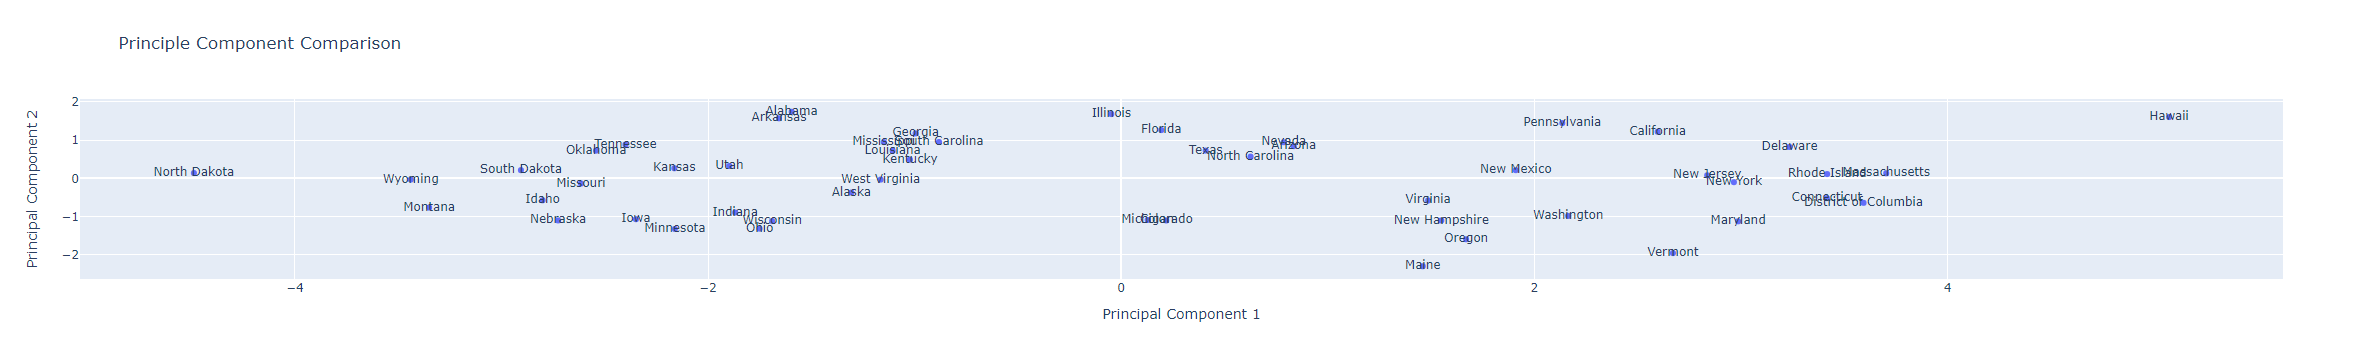

In [ ]:
# This code selects death data for specific states ('ID', 'CO', 'TX', 'NY', 'HA') from the dataset and assigns it to the variable "notable_deaths".

from datetime import datetime
notable_states = ['ID', 'CO', 'TX', 'NY', 'HA']
notable_deaths = deaths[deaths['state'].isin(notable_states)]
notable_deaths

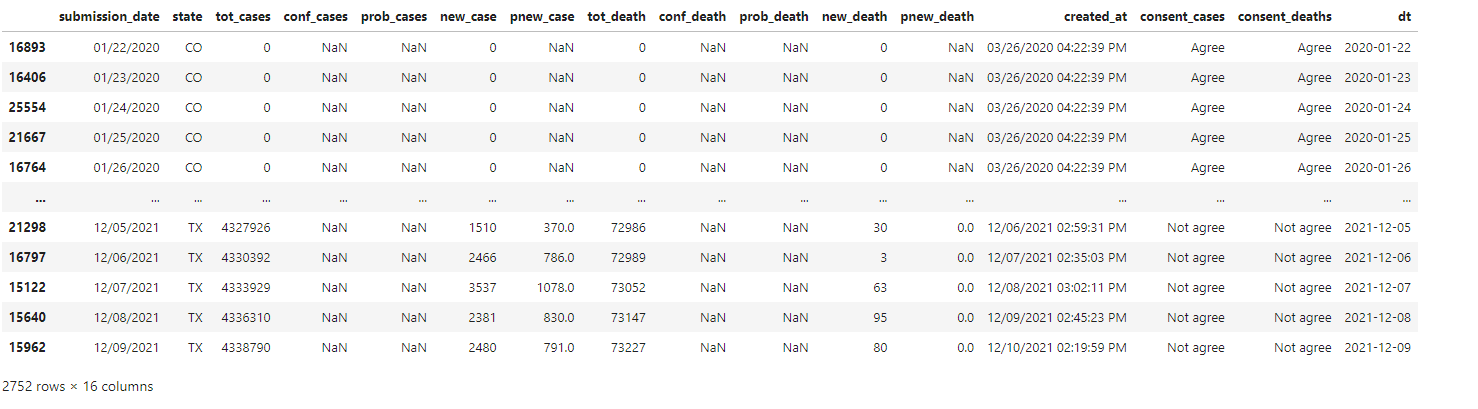

In [ ]:
# This code creates a scatter plot showing the total deaths over time for specific states ('ID', 'CO', 'TX', 'NY', 'HA') from the dataset, with each state represented by a different color.

sns.scatterplot(x='submission_date', y='tot_death', data=notable_deaths, hue='state', ec=None)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('total deaths by state')

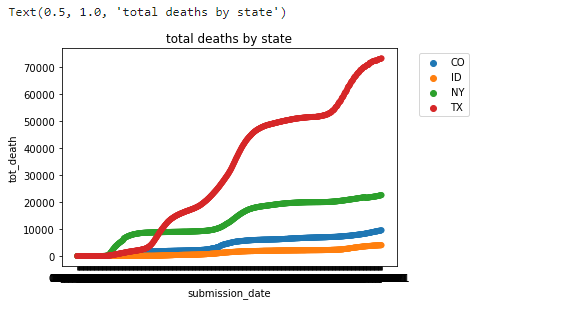

In [ ]:
# This code generates a scatter plot illustrating the total number of cases over time for certain states ('ID', 'CO', 'TX', 'NY', 'HA') from the dataset. Each state is distinguished by a unique color in the plot. 

sns.scatterplot(x='submission_date', y='tot_cases', data=notable_deaths, hue='state', ec=None)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('total cases by state')

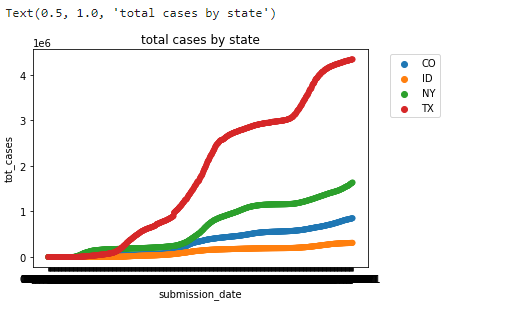

In [ ]:
# This code selects vaccination data for specific states ('Idaho', 'Colorado', 'Texas', 'New York', 'Hawaii') from the dataset. It converts the date strings to datetime objects and then replaces the state names with their corresponding abbreviations.

notable_states2=['Idaho', 'Colorado', 'Texas', 'New York', 'Hawaii']
notable_vax = vaccinations[vaccinations['Province_State'].isin(notable_states2)]
# notable_vax.loc['2020-01-01':'2021-12-09']
notable_vax['dt'] = notable_vax['Date'].apply(datetime.strptime, args=('%Y-%m-%d',))
notable_vax = notable_vax.replace({'Colorado': 'CO', 'Idaho':'ID', 'New York': 'NY', 'Texas':'TX'})
notable_vax = notable_vax.rename(columns={'Province_State':'state'})
notable_vax

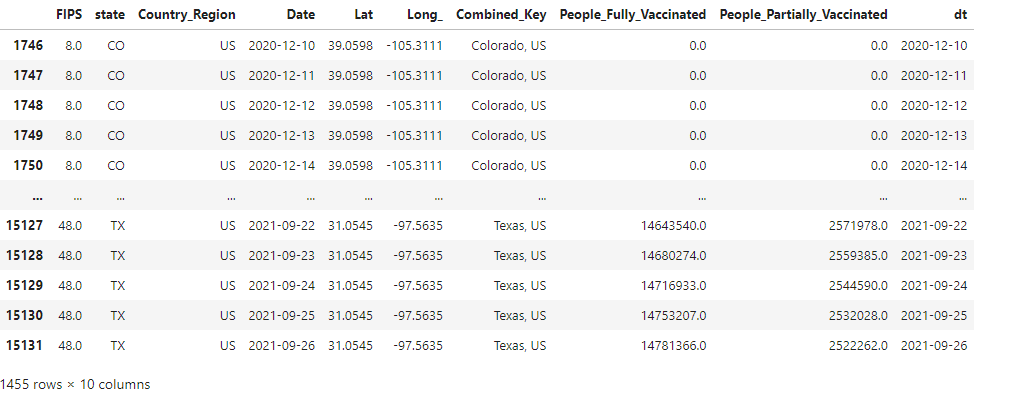

In [ ]:
# This code merges the vaccination and death data based on the common columns 'dt' and 'state'. Then, it groups the county data by state name and sums up the values. Finally, it selects population estimates for the state of Colorado from the grouped county data.

notable = notable_vax.merge(notable_deaths, how='inner', on=['dt','state'])
county_data_grouped = county_data.groupby('STNAME').agg(sum)
notable_county_data_grouped = county_data_grouped.loc[['Colorado', 'Idaho', 'Texas', 'New York']]
notable_county_data_grouped.loc['Colorado']['POPESTIMATE2020']

In [ ]:
# This code calculates various metrics related to vaccination and death rates per capita for the states of Colorado, Idaho, Texas, and New York. 
# It computes the partially vaccinated per capita, vaccination difference per capita, death rate per capita difference, percent change in vaccination, and percent change in death rate for each month.

colorado = notable[notable['state'] == 'CO']
colorado['month'] = pd.DatetimeIndex(colorado['dt']).month
colorado_month = colorado.groupby('month').agg(sum)
order_month = [2,3,4,5,6,7,8,9,10,1]
colorado_month['order'] = order_month
colorado_month= colorado_month.sort_values('order')
idaho = notable[notable['state'] == 'ID']
idaho['month'] = pd.DatetimeIndex(idaho['dt']).month
idaho_month = idaho.groupby('month').agg(sum)
idaho_month['order'] = order_month
idaho_month  = idaho_month.sort_values('order')
texas = notable[notable['state'] == 'TX']
texas['month'] = pd.DatetimeIndex(texas['dt']).month
texas_month = texas.groupby('month').agg(sum)
texas_month['order'] = order_month
texas_month  = texas_month.sort_values('order')
newyork = notable[notable['state'] == 'NY']
newyork['month'] = pd.DatetimeIndex(newyork['dt']).month
newyork_month = newyork.groupby('month').agg(sum)
newyork_month['order'] = order_month
newyork_month  = newyork_month.sort_values('order')
colorado_month['Partially_Vaccinated_Per_Capita'] = colorado_month['People_Partially_Vaccinated'] / notable_county_data_grouped.loc['Colorado']['POPESTIMATE2020']
idaho_month['Partially_Vaccinated_Per_Capita'] = idaho_month['People_Partially_Vaccinated'] / notable_county_data_grouped.loc['Idaho']['POPESTIMATE2020']
texas_month['Partially_Vaccinated_Per_Capita'] = texas_month['People_Partially_Vaccinated'] / notable_county_data_grouped.loc['Texas']['POPESTIMATE2020']
newyork_month['Partially_Vaccinated_Per_Capita'] = newyork_month['People_Partially_Vaccinated'] / notable_county_data_grouped.loc['New York']['POPESTIMATE2020']
colorado_month['Vaccination_Diff_Per_Capita'] = colorado_month['Partially_Vaccinated_Per_Capita'].diff()
idaho_month['Vaccination_Diff_Per_Capita'] = idaho_month['Partially_Vaccinated_Per_Capita'].diff()
texas_month['Vaccination_Diff_Per_Capita'] = texas_month['Partially_Vaccinated_Per_Capita'].diff()
newyork_month['Vaccination_Diff_Per_Capita'] = newyork_month['Partially_Vaccinated_Per_Capita'].diff()
colorado_month['Per Capita Death Rate Diff'] = (colorado_month['new_death'] / notable_county_data_grouped.loc['Colorado']['POPESTIMATE2020'])
idaho_month['Per Capita Death Rate Diff'] = (idaho_month['new_death'] / notable_county_data_grouped.loc['Idaho']['POPESTIMATE2020'])
texas_month['Per Capita Death Rate Diff'] = (texas_month['new_death'] / notable_county_data_grouped.loc['Texas']['POPESTIMATE2020'])
newyork_month['Per Capita Death Rate Diff'] = (newyork_month['new_death'] / notable_county_data_grouped.loc['New York']['POPESTIMATE2020'])
colorado_month['Percent Change Vaccination'] =  colorado_month['People_Partially_Vaccinated'].pct_change()
idaho_month['Percent Change Vaccination'] =  idaho_month['People_Partially_Vaccinated'].pct_change()
texas_month['Percent Change Vaccination'] =  texas_month['People_Partially_Vaccinated'].pct_change()
newyork_month['Percent Change Vaccination'] =  newyork_month['People_Partially_Vaccinated'].pct_change()
colorado_month['Percent Change Death'] =  colorado_month['Per Capita Death Rate Diff'].pct_change()
idaho_month['Percent Change Death'] =  idaho_month['Per Capita Death Rate Diff'].pct_change()
newyork_month['Percent Change Death'] =  newyork_month['Per Capita Death Rate Diff'].pct_change()
texas_month['Percent Change Death'] =  texas_month['Per Capita Death Rate Diff'].pct_change()
colorado_month['Percent Change Full Vaccination'] =  colorado_month['People_Fully_Vaccinated'].pct_change()
idaho_month['Percent Change Full Vaccination'] =  idaho_month['People_Fully_Vaccinated'].pct_change()
texas_month['Percent Change Full Vaccination'] =  texas_month['People_Fully_Vaccinated'].pct_change()
newyork_month['Percent Change Full Vaccination'] =  newyork_month['People_Fully_Vaccinated'].pct_change()
texas_month

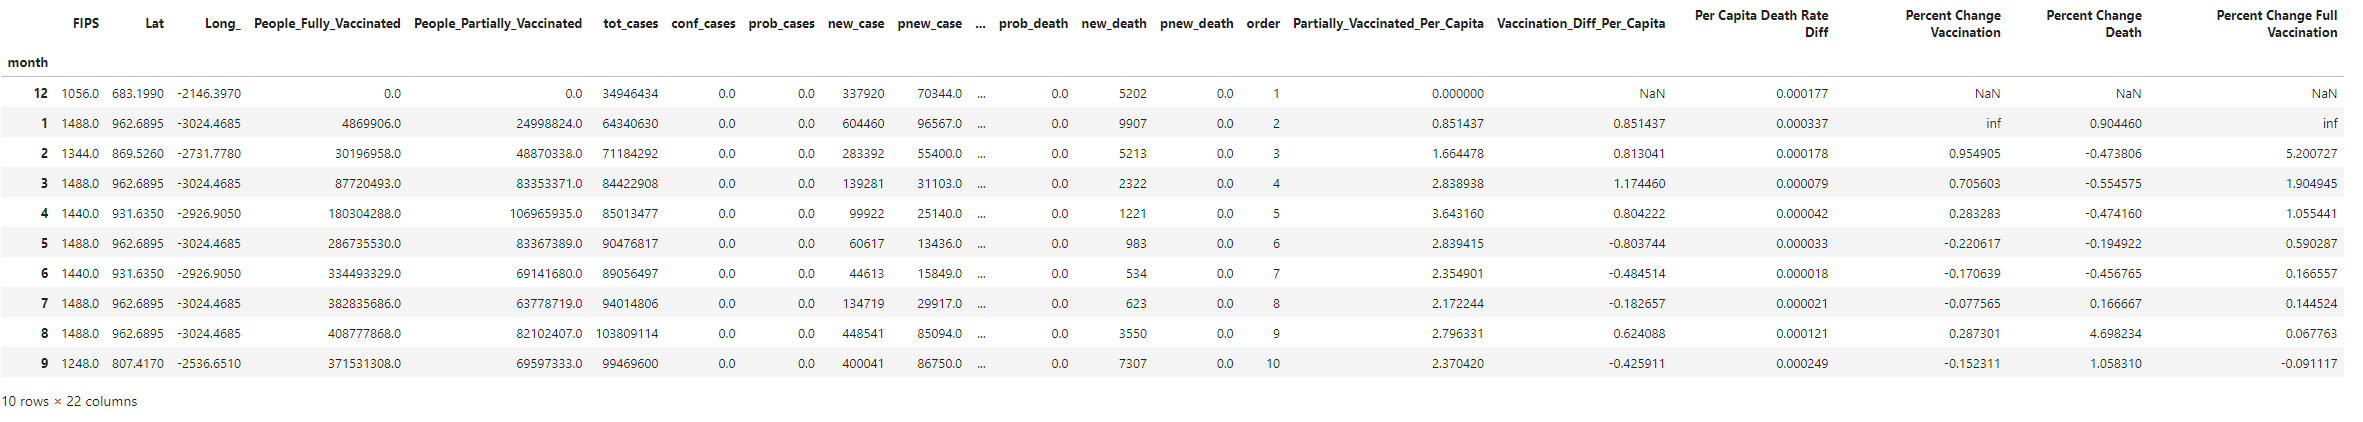

In [ ]:
# This code plots the percent change in death rate over time for New York state.

plt.plot(newyork_month.index, newyork_month['Percent Change Death'])

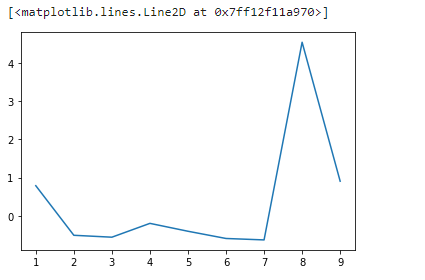

In [ ]:
# This code plots the percent change in vaccination rate over time for New York state.

plt.plot(newyork_month.index, newyork_month['Percent Change Vaccination'])

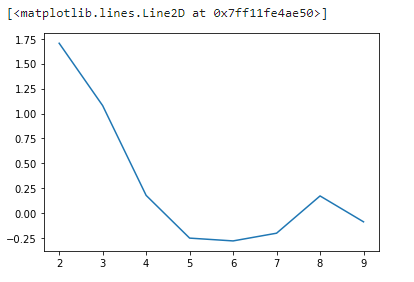

In [ ]:
# This code plots the percent change in the full vaccination rate over time for New York state.

plt.plot(newyork_month.index, newyork_month['Percent Change Full Vaccination'])

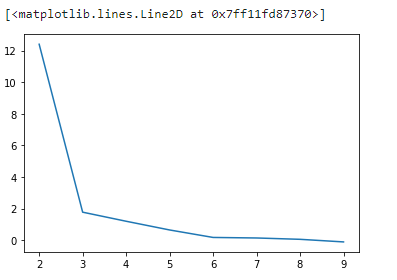

In [ ]:
# This code plots the percent change in death rate over time for Colorado

plt.plot(colorado_month.index, colorado_month['Percent Change Death'])

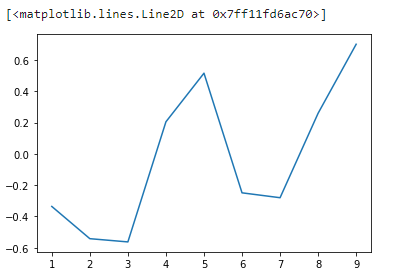

In [ ]:
# This code plots the percent change in vaccination rate over time for Colorado

plt.plot(colorado_month.index, colorado_month['Percent Change Vaccination'])

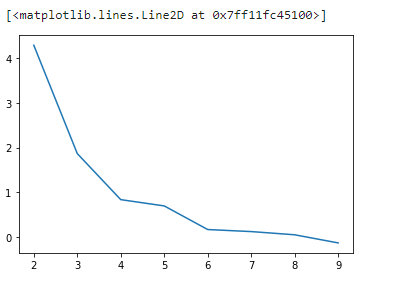

In [ ]:
# This code plots the percent change in full vaccination rate over time for Colorado

plt.plot(colorado_month.index, colorado_month['Percent Change Full Vaccination'])

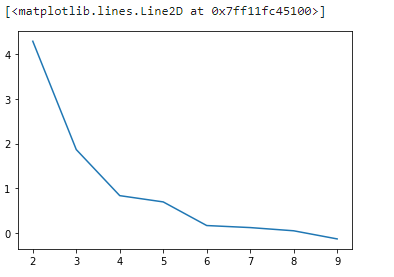

In [ ]:
# This code plots the percent change in death rate over time for Idaho

plt.plot(idaho_month.index, idaho_month['Percent Change Death'])

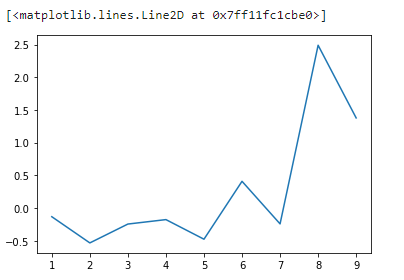

In [ ]:
# This code plots the percent change in vaccination rate over time for Idaho

plt.plot(idaho_month.index, idaho_month['Percent Change Vaccination'])

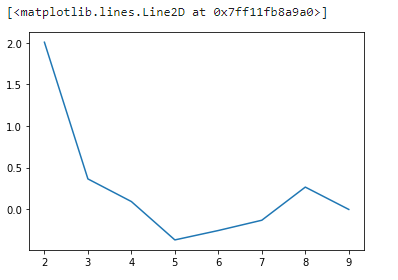

In [ ]:
# This code plots the percent change in full vaccination rate over time for Idaho

plt.plot(idaho_month.index,idaho_month['Percent Change Full Vaccination'])

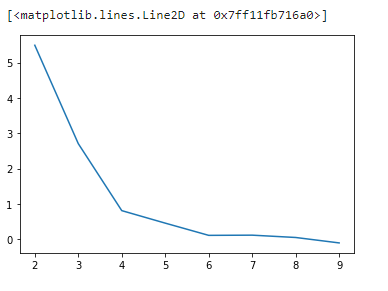

In [ ]:
# This code plots the percent change in death rate over time for Texas

plt.plot(texas_month.index, texas_month['Percent Change Death'])

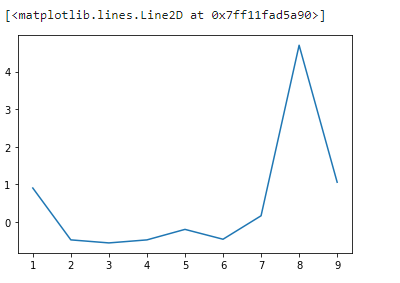

In [ ]:
# This code plots the percent change in vaccination rate over time for Texas

plt.plot(texas_month.index, texas_month['Percent Change Vaccination'])

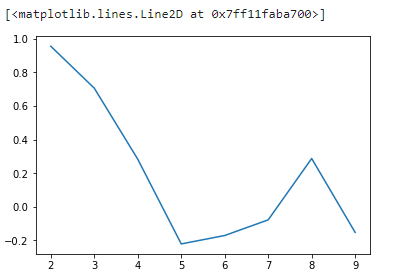

In [ ]:
# This code plots the percent change in full vaccination rate over time for Texas

plt.plot(texas_month.index,texas_month['Percent Change Full Vaccination'])

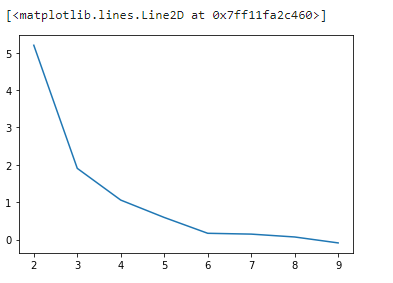

In [ ]:
# This code fits a linear regression model to predict the percent change in full vaccination rate based on the percent change in death rate for the state of Colorado
# Then it predicts the precent change in full vaccination rate using the model and compares it with the actual percent change in full vaccination rate

colorado_month2 = colorado_month.iloc[1:]
X = colorado_month2[['Percent Change Death']].iloc[2:]
y = colorado_month2['Percent Change Full Vaccination'].iloc[2:]
model_month_colorado = LinearRegression().fit(X, y)

model_month_predict_colorado = model_month_colorado.predict(X[['Percent Change Death']])

# train_rmse_cpc = np.sqrt(np.mean((y_q5d_train - train_y_predict)**2))
# test_rmse_cpc = np.sqrt(np.mean((y_q5d_test - test_y_predict)**2))

# train_rmse_cpc, test_rmse_cpc
model_month_predict_colorado[6], colorado_month['Percent Change Full Vaccination'].iloc[7]

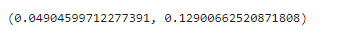

In [ ]:
# This code fits a linear regression model to predict the percent change in full vaccination rate based on the percent change in death rate for the state of Idaho
# Then, it predicts the percent change in full vaccination rate using the model and compares it with the actual percent change in full vaccination rate

idaho_month2 = idaho_month.iloc[1:]
X = idaho_month2[['Percent Change Death']].iloc[2:]
y = idaho_month2['Percent Change Full Vaccination'].iloc[2:]
model_month_idaho = LinearRegression().fit(X, y)

model_month_predict_idaho = model_month_idaho.predict(X[['Percent Change Death']])

# train_rmse_cpc = np.sqrt(np.mean((y_q5d_train - train_y_predict)**2))
# test_rmse_cpc = np.sqrt(np.mean((y_q5d_test - test_y_predict)**2))

# train_rmse_cpc, test_rmse_cpc
model_month_predict_idaho[6], idaho_month['Percent Change Full Vaccination'].iloc[6]

In [ ]:
# This code fits a linear regression model to predict the percent change in full vaccination rate based on the percent change in death rate for the state of New York
# Then, it predicts the percent change in full vaccination rate using the model and compares it with the actual percent change in full vaccination rate

newyork_month2 = newyork_month.iloc[1:]
X = newyork_month2[['Percent Change Death']].iloc[2:]
y = newyork_month2['Percent Change Full Vaccination'].iloc[2:]
model_month_newyork = LinearRegression().fit(X, y)

model_month_predict_newyork = model_month_newyork.predict(X[['Percent Change Death']])

# train_rmse_cpc = np.sqrt(np.mean((y_q5d_train - train_y_predict)**2))
# test_rmse_cpc = np.sqrt(np.mean((y_q5d_test - test_y_predict)**2))

# train_rmse_cpc, test_rmse_cpc
model_month_predict_newyork[6], newyork_month['Percent Change Full Vaccination'].iloc[7]

### EDA 2.)

For my second exploratory data analysis (EDA), I opted to aggregate daily total per capita death and vaccination rates across the entire United States. This approach differed from my initial EDA, providing a fresh perspective. I hypothesized that this nationwide aggregation, analyzed day by day, would reveal distinct patterns compared to my first analysis. By scrutinizing this data, I aimed to detect anomalies deviating from expected trends, such as consistent increases in death and vaccination rates. These deviations could offer valuable insights into my hypothesis.

In [ ]:
# This code preprocesses vaccination data, aligns state names with their abbreviations, merges vaccination and death data, groups it by month, calculates percentage changes, and trains a linear regression model to predict vaccination percentage change based on death percentage change.

all_vacc = vaccinations
# notable_vax.loc['2020-01-01':'2021-12-09']
all_vacc['dt'] = all_vacc['Date'].apply(datetime.strptime, args=('%Y-%m-%d',))
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
all_vacc = all_vacc.replace(us_state_to_abbrev)
all_vacc = all_vacc.rename(columns={'Province_State':'state'})
all_state = all_vacc.merge(deaths, how='inner', on=['dt','state'])
all_state['month'] = pd.DatetimeIndex(all_state['Date']).month
all_state_by_month = all_state.groupby('month').agg(sum)
order_month = [2,3,4,5,6,7,8,9,10,1]
all_state_by_month['order'] = order_month
all_state_by_month = all_state_by_month.sort_values('order')
all_state_by_month['Percent Change Vaccination'] =  all_state_by_month['People_Partially_Vaccinated'].pct_change()
all_state_by_month['Percent Change Full Vaccination'] =  all_state_by_month['People_Fully_Vaccinated'].pct_change()
all_state_by_month['Percent Change Death'] = all_state_by_month['new_death'].pct_change()

death_vs_vacc_model = LinearRegression().fit(all_state_by_month[['Percent Change Death']].iloc[2:], all_state_by_month['Percent Change Vaccination'].iloc[2:])

In [ ]:
# This code calculates the RMSE for the predicted percentage change in vaccination rates using a linear regression model based on the actual percentage change in deaths.

death_vs_vacc_pred = death_vs_vacc_model.predict(all_state_by_month[['Percent Change Death']].iloc[2:])
rmse_death_vs_vacc = (np.sqrt(np.mean((all_state_by_month['Percent Change Vaccination'].iloc[2:] - death_vs_vacc_pred)**2)))
rmse_death_vs_vacc

In [ ]:
# This code plots the predicted and actual percentage change in vaccination rates over the months of February to September 2021, using a line plot.

plt.subplots()
sns.lineplot(np.arange(2,10), death_vs_vacc_pred, label = 'Predicted')
sns.lineplot(np.arange(2,10), all_state_by_month['Percent Change Vaccination'].iloc[2:], label = 'Actual')
plt.title("Percent Change in Vaccination Over the Months of February to September 2021")
plt.xlabel('Month')

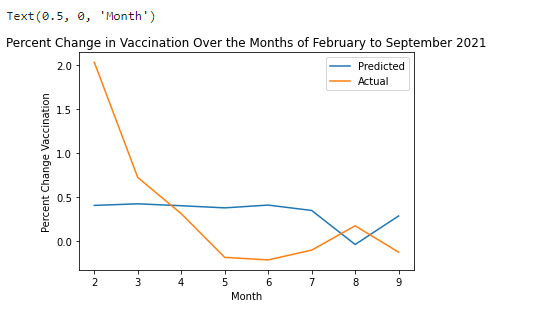

In [ ]:
# The code generates a line plot showing the mean squared error (MSE) of the model's predictions compared to the actual percentage change in vaccination rates over the months of February to September 2021.

predicted_minus_actual = (death_vs_vacc_pred - all_state_by_month['Percent Change Vaccination'].iloc[2:])**2
sns.lineplot(np.arange(2,10), predicted_minus_actual)
plt.xlabel('Month')
plt.ylabel('MSE of Model')
plt.title('MSE of Model For Each Month between February to September 2021')

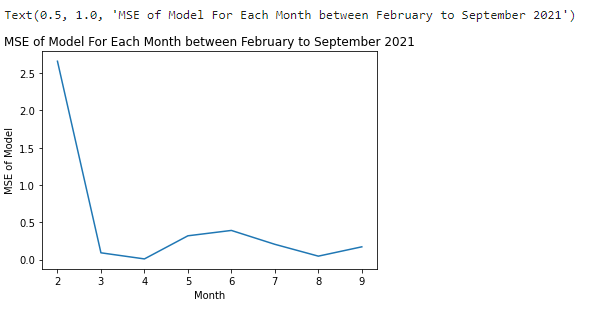

In [ ]:
# The code fits a linear regression model to predict the number of people partially vaccinated based on the total deaths
# It then predicts the number of people partially vaccinated using this model and plots the time series of these predictions over the dates provided in the dataset

time_t = all_state[['People_Partially_Vaccinated']].iloc[1:]
time_t_minus_one = all_state[['People_Partially_Vaccinated']].iloc[:-1]
time_model = LinearRegression().fit(time_t_minus_one[['People_Partially_Vaccinated']], time_t['People_Partially_Vaccinated'])
death_vs_vacc_model_time = LinearRegression().fit(all_state[['tot_death']], all_state['People_Partially_Vaccinated'])
death_vs_vacc_array = death_vs_vacc_model_time.predict(all_state[['tot_death']])
death_vs_vacc_df = pd.DataFrame(death_vs_vacc_array)
time_model_predict_with_death = time_model.predict(death_vs_vacc_df[[0]])
sns.lineplot(all_state['Date'], time_model_predict_with_death)
plt.title('Time Series Model of the Number of People Partially Vaccinated Using the Predictions from the Model: Total Deaths vs. People Partially Vaccinated')
plt.ylabel('Number of People')

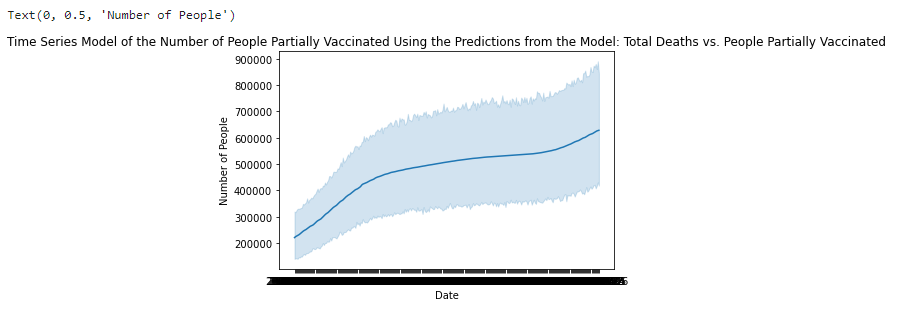

In [ ]:
# This code plots a time series model predicting the number of people partially vaccinated based on the previous number of people partially vaccinated

time_model_predict = time_model.predict(time_t_minus_one[['People_Partially_Vaccinated']])
sns.lineplot(all_state['Date'].iloc[1:], time_model_predict)
plt.title('Time Series Model of the Number of People Partially Vaccinated')
plt.ylabel('Number of People')

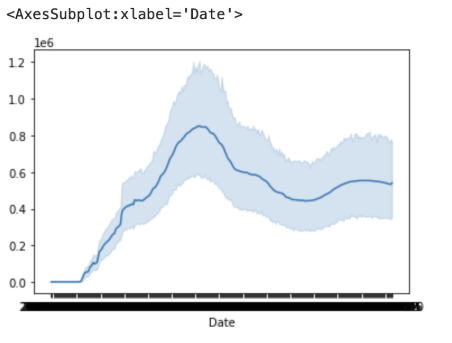

In [ ]:
# This code plots the percent change in partial vaccination over all available dates for the USA
# It then identifies the date with the maximum percent change in partial vaccination

plt.plot(all_state_by_date.index, all_state_by_date['partial_vax_per_capita'])
plt.title("USA Percent Change in Partial Vaccination over all Available Dates")
plt.xlabel("Date")
plt.ylabel("Percent Change in Partial Vaccination")
np.max(all_state_by_date['partial_vax_per_capita'])
all_state_by_date['partial_vax_per_capita'].idxmax(0.14237115941655223)

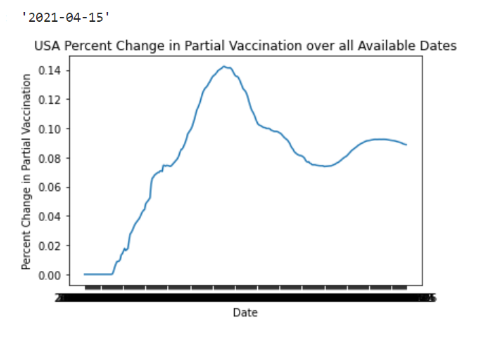

In [ ]:
# This code plots the percent change in full vaccination over all available dates for the USA.

plt.plot(all_state_by_date.index, all_state_by_date['full_vax_per_capita'])
plt.title("USA Percent Change in Full Vaccination over all Available Dates")
plt.xlabel("Date")
plt.ylabel("Percent change in Full Vaccination")

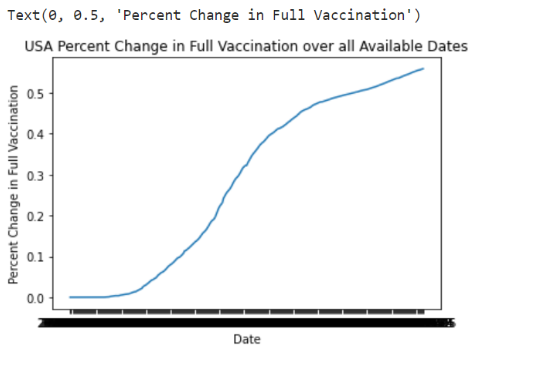

In [ ]:
# The code plots the percent change in deaths over all available dates for the USA

plt.plot(all_state_by_date.index, all_state_by_date['tot_death_per_capita'])
plt.title("USA Percent Change in Deaths over all Available Dates")
plt.xlabel("Date")
plt.ylabel("Percent Change in Deaths")

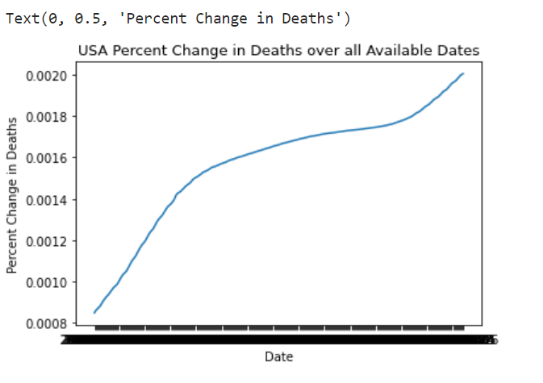

In [ ]:
# This code performs time series predictions of the month-to-month percent changes in people partially vaccinated.

time_percent_change_vaccination_t = all_state_by_month[['Percent Change Vaccination']].iloc[3:10]
time_percent_change_vaccination_t_minus_one = all_state_by_month[['Percent Change Vaccination']].iloc[2:9]


time_model_percent_change_vacc = LinearRegression().fit(time_percent_change_vaccination_t_minus_one[['Percent Change Vaccination']], time_percent_change_vaccination_t['Percent Change Vaccination'])
time_model_percent_change_predict_vacc = time_model_percent_change_vacc.predict(all_state_by_month[['Percent Change Vaccination']].iloc[2:])
sns.lineplot(np.arange(2,10), time_model_percent_change_predict_vacc)
plt.title('Time Series Predictions of Month to Month Percent Changes in People Partially Vaccinated')
plt.xlabel('Month')
plt.ylabel('Percent Change')

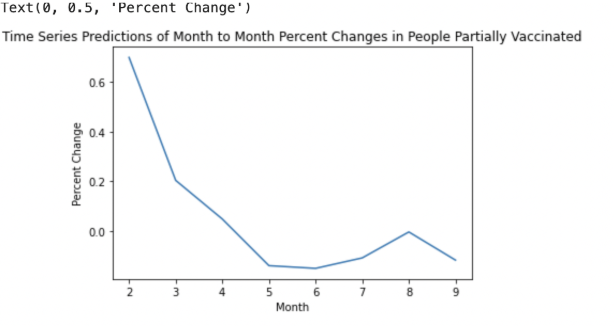

In [ ]:
# This code generates time series predictions of month-to-month percent changes in people partially vaccinated using predictions from a model based on the percent change in deaths versus the percent change partially vaccinated 

vacc_v_death_X = (all_state_by_month[['Percent Change Death']].iloc[2:])
vacc_v_death_y = all_state_by_month['Percent Change Vaccination'].iloc[2:]

vacc_vs_death_month_model = LinearRegression().fit(vacc_v_death_X, vacc_v_death_y)
vacc_v_death_predict =  vacc_vs_death_month_model.predict(all_state_by_month[['Percent Change Death']].iloc[2:])
vacc_v_death_predict_df = pd.DataFrame(vacc_v_death_predict)
time_model_percent_change_vacc_vs_death = time_model_percent_change_vacc.predict(vacc_v_death_predict_df[[0]])
sns.lineplot(np.arange(2,10), time_model_percent_change_vacc_vs_death)
plt.title('Time Series Predictions of Month to Month Percent Changes in People Partially Vaccinated Using the Predictions from the Model: Percent Change Deaths vs Percent Change Partially Vaccinated')
plt.xlabel('Month')
plt.ylabel('Percent Change')

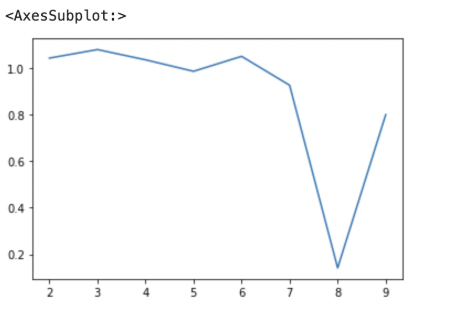

## Results

### The graphs consistently support my hypothesis across the four different states I chose to analyze. They consistently show that the rates of individuals partially vaccinating tend to spike following a spike in deaths. This trend is particularly noticeable right before the fifth month for partially vaccinated data in all four states. The percent change in vaccination can be understood as depicting those receiving their first dose, contrasting with percent change in full vaccination, which is more like a cumulative sum of vaccinations. Most people get vaccinated almost immediately, and as fewer remain unvaccinated, the percent change for partial vaccination begins to drop off, resulting in an inverse log-shaped curve. However, in all cases (the states I chose to examine based on PCA), when there is a spike in death rates, there is immediately a slight increase in the rate at which individuals are vaccinated, creating a distinct hump in an otherwise smooth curve.

### To summarize, any spike in the percent change in the number of deaths for a given state leads to a distinct jump in the percent change of those getting vaccinated, resulting in a slight, but undeniable, increase in the expectedly diminishing rate of full vaccination. My second EDA furthered this analysis by showing that only partially vaccinated data deviated from the expected trend of a consistent increase in death/vaccination rates. In fact, the highest peak value from my second EDA graph for the number of people partially vaccinated per capita is April 15th, 2021, which coincides roughly with the exact date that shows a reversal from a downward trend to an upward trend in partial vaccination percentage change rates for all four states in my first EDA. This evidence suggests that this period marks an unusual increase in partial vaccinations, likely attributed to spikes in death rates between the 2nd and 4th months observed in each state.